**Gamers Club Subscription Predicion**

<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/906490/header.jpg?t=1651026337" alt="some text" width=500 height=400 align="left">

An end-to-end Data Science project with a classification as solution

**Table of Contents**

* [Project Solution Planning](#section-one)
* [Business Problem](#section-two)
* [Imports](#section-three)
* [Loading Data](#section-four)
* [Data Description](#section-five)
    - [Rename Columns](#subsection-five-one)
    - [Data Dimension](#subsection-five-two)
    - [Data Types](#subsection-five-three)
    - [Check NA Values](#subsection-five-four)
    - [Fillout NAs](#subsection-five-five)
    - [Change dtypes](#subsection-five-six)
    - [Descriptive Statistics](#subsection-five-seven)
* [Feature Engineering](#section-six)
* [Variable Filtering](#section-seven)
* [Exploratory Data Analysis (EDA)](#section-eight)
* [Data Preparation](#section-nine)
* [Feature Selection](#section-ten)
* [Machine Learning Models](#section-eleven)
* [Hyperparameter Fine tunning](#section-twelve)
* [Error Interpretation](#section-thirteen)
* [Model Deployment](#section-fourteen)

## 1 PROJECT SOLUTION PLANNING
<a id="section-one"></a>

### Input

1. Business problem
    - The CFO wanted to reinvest in a premium servers capacities, therefore, he need to know how much revenue each player will bring so he can invest it now by knowing the amount of players that will be playing.
    
2. Datasets:

    - **tb_lobby_stats_player.csv**
    - **tb_medalha.csv**
    - **tb_players_medalha.csv**
    - **tb_players.csv**


### Output


1. Deliverables:

- Model's performance and results report with the following topics:
    - What's the probability of a player pay for subscription for the next 30 days?
    - ~Predictions will be available through a Telegram Bot where stakeholders can acess the prediction by a smartphone~
             
2. Business Report with all insights

### Tasks

**Project Development Method**

The project was developed based on the CRISP-DS (Cross-Industry Standard Process - Data Science, a.k.a. CRISP-DM) project management method, with the following steps:

- Project Planning
- Business Understanding;
- Data Collection;
- Data Cleaning;
- Exploratory Data Analysis (EDA);
- Data Preparation;
- Machine Learning Modelling and fine-tuning;
- Model and Business performance evaluation / Results;
- Model deployment.


<img src="https://www.researchgate.net/profile/Youssef-Tounsi-2/publication/341627969/figure/fig1/AS:903550875996160@1592434724532/CRISP-DM-data-mining-framework.png" alt="some text" width=500 height=400 align="left">


## 2 BUSINESS PROBLEM
<a id="section-two"></a>

Gamers Club 

- OpeOperator of an E-sports platform intended to transform competitive matches of online games into a professional sport.

- The company's platform provides the complete lifecycle for the eSports enthusiast, from classes/training to professional championships, the platform has everything the aspirant professional gamer needs to train, play and compete, enabling users to get gaming experience and to help them learn and improve the way they play.

- Business Model: 

The problem:
- The CFO wanted to reinvest in a premium servers capacities, therefore, he need to know how much revenue each player will bring so he can invest it now by knowing the amount of players that will be playing.

Goal:
- Predict players subscription

Deliverables:

- Model's performance and results report with the following topics:
    - What's the probability of a player pay for subscription for the next 30 days?
    - ~Predictions will be available through a Telegram Bot where stakeholders can acess the prediction by a smartphone~

### Flipbook Business Model

the idea here is to get a better business understanding so I can see where I could aggregate more value with data science

1. **Acquisition Chanel:**
    - Inherent virality
    - Paid media
    - Social Media
    - Influencers gamers
    
2. **Sales Strategy:**
    - Freemium

3. **Revenue Model:**
    - Recurring subscription

4. **Product Type:**
    - Plataform
    - Software (anti-cheat)

5. **Delivery Model:**
    - Hosted service
    - Digital delivery

## 3 IMPORTS
<a id="section-three"></a>

In [1]:
import pandas as pd

### 3.1 Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# Define the function to evaluate the models
def weighted_mean_absolute_error(df, y, yhat):
    weights = df.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-yhat))/(np.sum(weights)), 2)

def ml_error( df,model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    WMAE = weighted_mean_absolute_error(df, y, yhat)
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse,
                          'WMAE': WMAE}, index=[0])

# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    WMAE_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( weeks=k*22) #primeira semanada da venda realizada
        end_date_validation = x_training['date'].max() - datetime.timedelta( weeks=(k-1)*22) #ultima semana

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'weekly_sales'], axis=1 ) 
        ytraining = training['weekly_sales']

        # validation
        xvalidation = validation.drop( ['date', 'weekly_sales'], axis=1 )
        yvalidation = validation['weekly_sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( xvalidation, model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        rmse_list.append( m_result['RMSE'] )
        WMAE_list.append( m_result['WMAE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':  np.round( np.mean( mae_list ), 2 ).astype( str )  + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ),
                          'WMAE CV': np.round( np.mean( WMAE_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( WMAE_list ), 2 ).astype( str )}, index=[0] )


In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [12]:
#specify that all columns should be shown
pd.set_option('display.max_columns', None)

## 4 LOADING DATA
<a id="section-four"></a>

- For this project we will use data from matches that took place on Gamers Club servers. 
- They are matches referring to 2,500 players, with more than 30 statistics of their matches. Such as Kills, Assists, Kills, Flash Assist, Head Shot, etc.

In [14]:
#project home path for importing files
home_path = '/home/marxcerqueira/repos/gc-subs-prediction/'

#loading datasets available for this project
df_lobby_stats_player  = pd.read_csv(home_path + 'data/raw/tb_lobby_stats_player.csv', low_memory = False)
df_medals              = pd.read_csv(home_path + 'data/raw/tb_medalha.csv',  low_memory = False)
df_players_medals      = pd.read_csv(home_path + 'data/raw/tb_players_medalha.csv', low_memory = False)
df_players             = pd.read_csv(home_path + 'data/raw/tb_players.csv', low_memory = False)

In [13]:
#first look at the dataframes
df_lobby_stats_player.head()

idLobbyGame  idPlayer  idRoom  qtKill  qtAssist  qtDeath  qtHs  \
0            1         1       1       5         1       16     2   
1            2         1       2      24         3       18     6   
2            3         2       3       6         4       23     2   
3            3       391   27508      10         5       20     4   
4            4         2       4       8         4       26     6   

   qtBombeDefuse  qtBombePlant  qtTk  qtTkAssist  qt1Kill  qt2Kill  qt3Kill  \
0              0             0   0.0         0.0        3        1        0   
1              0             4   0.0         1.0        9        4        1   
2              0             1   0.0         1.0        4        1        0   
3              1             0   0.0         0.0        6        2        0   
4              0             2   0.0         0.0        4        2        0   

   qt4Kill  qt5Kill  qtPlusKill  qtFirstKill  vlDamage  qtHits  qtShots  \
0        0        0           0            1       911    25.0      212   
1        1        0           0            3      2933    54.0      597   
2        0        0           0            2      1117    31.0      207   
3        0        0           0            1      1740    63.0      411   
4        0        0           0            1      1696    51.0      324   

   qtLastAlive  qtClutchWon  qtRoundsPlayed descMapName  vlLevel  qtSurvived  \
0          0.0            0              17   de_mirage       10         1.0   
1          1.0            1              27     de_nuke        9         8.0   
2          0.0            0              25   de_mirage        2         2.0   
3          1.0            1              25   de_mirage       15         3.0   
4          0.0            0              30     de_nuke        2         4.0   

   qtTrade  qtFlashAssist  qtHitHeadshot  qtHitChest  qtHitStomach  \
0      2.0            0.0            3.0        13.0           4.0   
1      1.0            0.0            7.0        26.0          14.0   
2      3.0            0.0            3.0        15.0           8.0   
3      4.0            0.0            6.0        27.0          10.0   
4      4.0            2.0            8.0        19.0          12.0   

   qtHitLeftAtm  qtHitRightArm  qtHitLeftLeg  qtHitRightLeg  flWinner  \
0           2.0            2.0           1.0            0.0         0   
1           2.0            1.0           1.0            3.0         1   
2           1.0            2.0           0.0            2.0         0   
3           1.0            7.0           6.0            6.0         1   
4           2.0            3.0           2.0            5.0         0   

           dtCreatedAt  
0  2022-01-21 19:45:44  
1  2022-02-04 02:09:47  
2  2021-09-18 18:07:43  
3  2021-09-18 18:07:43  
4  2021-09-27 00:17:45

In [15]:
#first look at the dataframes
df_medals.head()

idMedal                  descMedal descTypeMedal
0        1             Membro Premium         MEDAL
1        2                      Elite         MEDAL
2        3                Membro Plus         MEDAL
3        4          Bom Comportamento         MEDAL
4        5  Já conquistou 25 Vitórias         MEDAL

In [8]:
#first look at the dataframes
df_players_medalha.head()

id  idPlayer  idMedal dtCreatedAt dtExpiration    dtRemove  flActive
0   1      1982        1  2018-10-04   2016-07-23  2016-07-24         0
1   2      1982        1  2018-12-12   2017-01-11  2017-01-12         0
2   3      1982        1  2019-01-08   2017-03-16  2017-03-17         0
3   4      1982        1  2018-12-09   2017-09-10  2017-09-11         0
4   5      1982        1  2018-10-04   2018-03-19  2018-03-20         0

In [9]:
#first look at the dataframes
df_players.head()

idPlayer  flFacebook  flTwitter  flTwitch descCountry dtBirth  \
0         1           0          0         0          cl     NaN   
1         2           0          0         0          br     NaN   
2         3           0          0         0          br     NaN   
3         4           0          0         0          br     NaN   
4         5           0          0         0          ar     NaN   

        dtRegistration  
0  2021-03-19 21:31:39  
1  2020-05-06 19:28:29  
2  2020-01-28 13:00:38  
3  2017-05-31 16:13:51  
4  2021-02-08 11:57:21

### 4.1 Merge datasets

The datasets keys here can be 'idPlayer', 'idMedal'

I created a book_players using SQL

You can see the code in the path: /book_player/query.sql

## 5 DATA DESCRIPTION
<a id="section-five"></a>

In [7]:
# #Copy dataset
# df1 = df0.copy()

### 5.1 Rename Columns
<a id="subsection-five-one"></a>

In [8]:
# cols_old = df1.columns

# snakecase = lambda x: inflection.underscore(x)

# cols_new = list( map( snakecase, cols_old ) )

# #Rename Columns

# df1.columns = cols_new

In [37]:
# checking cols transformation
# df1.columns

### 5.2 Data Dimension
<a id="subsection-five-two"></a>

In [45]:
df_lobby_stats_player.shape

(184152, 38)

In [ ]:
for t in tbl_names:
    print )

In [56]:
tbl = [df_lobby_stats_player, df_medals, df_players_medals, df_players]
# tbl_names = ['df_lobby_stats_player', 'df_medals', 'df_players_medals', 'df_players']

for t in tbl:
    print(f'\nNumber of Rows: {t.shape[0]}\
            \nNumber of Columns: {t.shape[1]}')


Number of Rows: 184152            
Number of Columns: 38

Number of Rows: 47            
Number of Columns: 3

Number of Rows: 32700            
Number of Columns: 7

Number of Rows: 2716            
Number of Columns: 7


### 5.3 Data Types
<a id="subsection-five-three"></a>

In [61]:
# checking features dtypes
for t in tbl:
    print(f'\n{t.dtypes}')


idLobbyGame         int64
idPlayer            int64
idRoom              int64
qtKill              int64
qtAssist            int64
qtDeath             int64
qtHs                int64
qtBombeDefuse       int64
qtBombePlant        int64
qtTk              float64
qtTkAssist        float64
qt1Kill             int64
qt2Kill             int64
qt3Kill             int64
qt4Kill             int64
qt5Kill             int64
qtPlusKill          int64
qtFirstKill         int64
vlDamage            int64
qtHits            float64
qtShots             int64
qtLastAlive       float64
qtClutchWon         int64
qtRoundsPlayed      int64
descMapName        object
vlLevel             int64
qtSurvived        float64
qtTrade           float64
qtFlashAssist     float64
qtHitHeadshot     float64
qtHitChest        float64
qtHitStomach      float64
qtHitLeftAtm      float64
qtHitRightArm     float64
qtHitLeftLeg      float64
qtHitRightLeg     float64
flWinner            int64
dtCreatedAt        object
dtype: obje

### 5.4 Check NA values
<a id="subsection-five-four"></a>

In [67]:
# checking NA values sum and its percentagem from total number of rows
missing_dfs = []
for t in tbl:
    missing_count = t.isnull().sum() # the count of missing values
    value_count = t.isnull().count() # the count of all values
    
    missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
    missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
    
    missing_dfs.append(missing_df)

In [79]:
missing_dfs

[                missing values count  percentage
 idLobbyGame                        0        0.00
 idPlayer                           0        0.00
 idRoom                             0        0.00
 qtKill                             0        0.00
 qtAssist                           0        0.00
 qtDeath                            0        0.00
 qtHs                               0        0.00
 qtBombeDefuse                      0        0.00
 qtBombePlant                       0        0.00
 qtTk                             120        0.07
 qtTkAssist                       120        0.07
 qt1Kill                            0        0.00
 qt2Kill                            0        0.00
 qt3Kill                            0        0.00
 qt4Kill                            0        0.00
 qt5Kill                            0        0.00
 qtPlusKill                         0        0.00
 qtFirstKill                        0        0.00
 vlDamage                           0        0.00


In [73]:
missing_dfs[0]

missing values count  percentage
idLobbyGame                        0        0.00
idPlayer                           0        0.00
idRoom                             0        0.00
qtKill                             0        0.00
qtAssist                           0        0.00
qtDeath                            0        0.00
qtHs                               0        0.00
qtBombeDefuse                      0        0.00
qtBombePlant                       0        0.00
qtTk                             120        0.07
qtTkAssist                       120        0.07
qt1Kill                            0        0.00
qt2Kill                            0        0.00
qt3Kill                            0        0.00
qt4Kill                            0        0.00
qt5Kill                            0        0.00
qtPlusKill                         0        0.00
qtFirstKill                        0        0.00
vlDamage                           0        0.00
qtHits                           120        0.07
qtShots                            0        0.00
qtLastAlive                      120        0.07
qtClutchWon                        0        0.00
qtRoundsPlayed                     0        0.00
descMapName                        0        0.00
vlLevel                            0        0.00
qtSurvived                       705        0.38
qtTrade                          705        0.38
qtFlashAssist                    705        0.38
qtHitHeadshot                    705        0.38
qtHitChest                       705        0.38
qtHitStomach                     705        0.38
qtHitLeftAtm                     705        0.38
qtHitRightArm                    705        0.38
qtHitLeftLeg                     705        0.38
qtHitRightLeg                    705        0.38
flWinner                           0        0.00
dtCreatedAt                        0        0.00

In [71]:
missing_df[2]

KeyError: 2

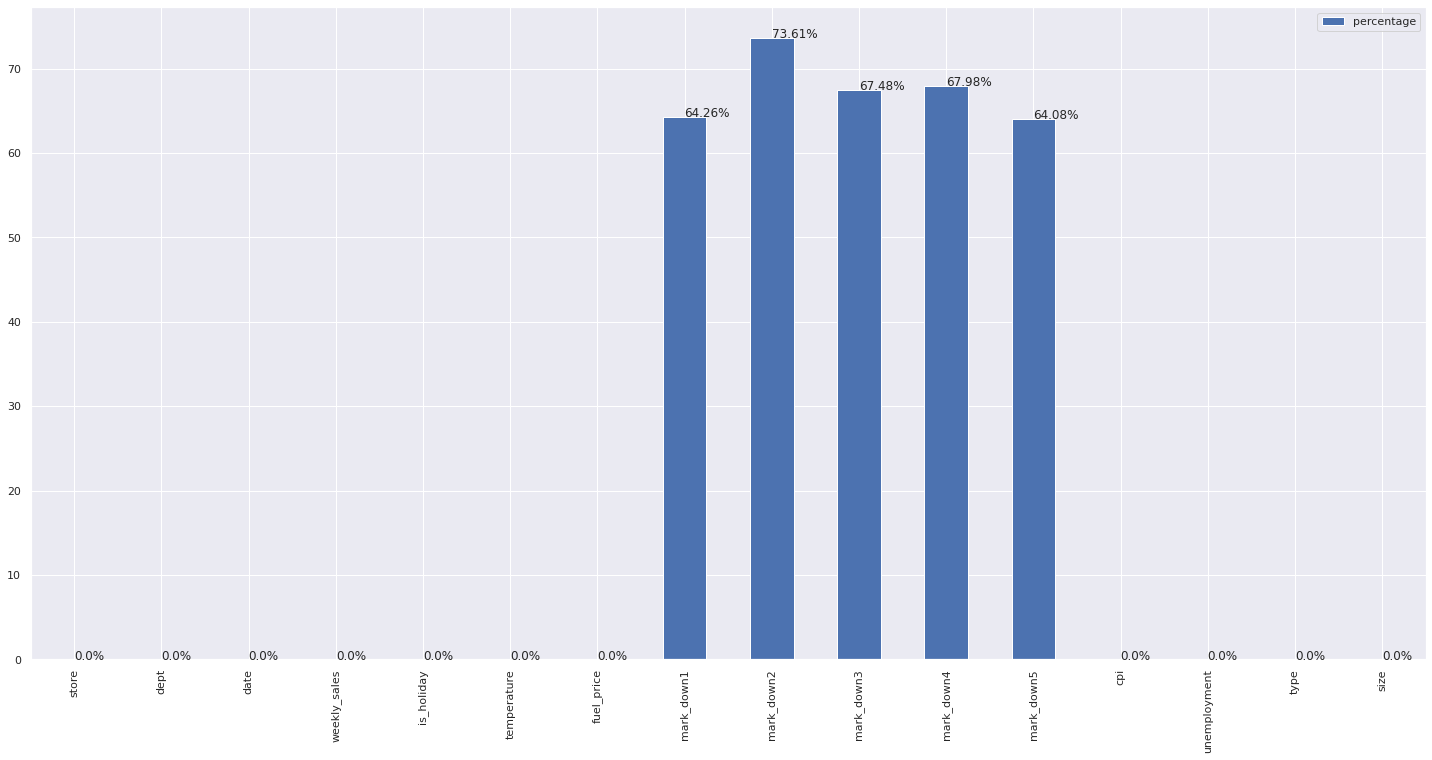

In [16]:
# missing na chart
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

- Markdown 1-5 columns have NAs, all other columns are complete.

- It contains lots of missing values, more than 64% of NAs in each markdown column. 

- They correspond to the promotional activities being carried out at different stores. 

- The promotional markdowns only started after November 2011 and is not running all the times at all the stores. So this makes sense why these columns have lot of NAs values. 

- Let's perform the exploratory data analysis and study their relationship with the weekly sales and then we will decide about these columns and the missing values

### 5.5 Fillout NA
<a id="subsection-five-five"></a>

In [9]:
# replacing NAs with 0
df1 = df1.fillna(0)

- replacing NAs with 0 even though this action will create more bias to the model
- during the next cicle of CRIPS we will take a deep look into it.

### 5.6 Change Types
<a id="subsection-five-six"></a>

In [11]:
df1.dtypes # checking datatypes transformation

store                    int64
dept                     int64
date            datetime64[ns]
weekly_sales           float64
is_holiday                bool
temperature            float64
fuel_price             float64
mark_down1             float64
mark_down2             float64
mark_down3             float64
mark_down4             float64
mark_down5             float64
cpi                    float64
unemployment           float64
type                    object
size                     int64
dtype: object

### 5.7 Descriptive Statistics
<a id="subsection-five-seven"></a>

- It's usefull to get the first knowledge of the business problem over the features and we can detect some data erros

In [20]:
# média: é o ponto médio (central) dentro de uma nuvem de pontos (cada linha do dataset)
# std: mostra o quao disperto os pontos estão em torno da média
# CV : std/media mostra a disperção dos dados em torno da média +1, -1

In [21]:
df1.describe().T

count           mean           std        min           25%           50%            75%            max
store         421570.0      22.200546     12.785297      1.000     11.000000      22.00000      33.000000      45.000000
dept          421570.0      44.260317     30.492054      1.000     18.000000      37.00000      74.000000      99.000000
weekly_sales  421570.0   15981.258123  22711.183519  -4988.940   2079.650000    7612.03000   20205.852500  693099.360000
temperature   421570.0      60.090059     18.447931     -2.060     46.680000      62.09000      74.280000     100.140000
fuel_price    421570.0       3.361027      0.458515      2.472      2.933000       3.45200       3.738000       4.468000
mark_down1    421570.0    2590.074819   6052.385934      0.000      0.000000       0.00000    2809.050000   88646.760000
mark_down2    421570.0     879.974298   5084.538801   -265.760      0.000000       0.00000       2.200000  104519.540000
mark_down3    421570.0     468.087665   5528.873453    -29.100      0.000000       0.00000       4.540000  141630.610000
mark_down4    421570.0    1083.132268   3894.529945      0.000      0.000000       0.00000     425.290000   67474.850000
mark_down5    421570.0    1662.772385   4207.629321      0.000      0.000000       0.00000    2168.040000  108519.280000
cpi           421570.0     171.201947     39.159276    126.064    132.022667     182.31878     212.416993     227.232807
unemployment  421570.0       7.960289      1.863296      3.879      6.891000       7.86600       8.572000      14.313000
size          421570.0  136727.915739  60980.583328  34875.000  93638.000000  140167.00000  202505.000000  219622.000000

In [22]:
# separate numerical and categorical attributes
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

#### 5.7.1 Numerical Attributes

In [23]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

attributes        min            max          range           mean        median           std       skew    kurtosis
0          store      1.000      45.000000      44.000000      22.200546      22.00000     12.785282   0.077763   -1.146503
1           dept      1.000      99.000000      98.000000      44.260317      37.00000     30.492018   0.358223   -1.215571
2   weekly_sales  -4988.940  693099.360000  698088.300000   15981.258123    7612.03000  22711.156583   3.262008   21.491290
3    temperature     -2.060     100.140000     102.200000      60.090059      62.09000     18.447909  -0.321404   -0.635922
4     fuel_price      2.472       4.468000       1.996000       3.361027       3.45200      0.458514  -0.104901   -1.185405
5     mark_down1      0.000   88646.760000   88646.760000    2590.074819       0.00000   6052.378756   4.731304   34.917236
6     mark_down2   -265.760  104519.540000  104785.300000     879.974298       0.00000   5084.532770  10.645956  145.421293
7     mark_down3    -29.100  141630.610000  141659.710000     468.087665       0.00000   5528.866895  14.922341  248.095371
8     mark_down4      0.000   67474.850000   67474.850000    1083.132268       0.00000   3894.525326   8.077666   86.242339
9     mark_down5      0.000  108519.280000  108519.280000    1662.772385       0.00000   4207.624330   9.964519  183.408065
10           cpi    126.064     227.232807     101.168807     171.201947     182.31878     39.159229   0.085219   -1.829714
11  unemployment      3.879      14.313000      10.434000       7.960289       7.86600      1.863294   1.183743    2.731217
12          size  34875.000  219622.000000  184747.000000  136727.915739  140167.00000  60980.511002  -0.325850   -1.206346

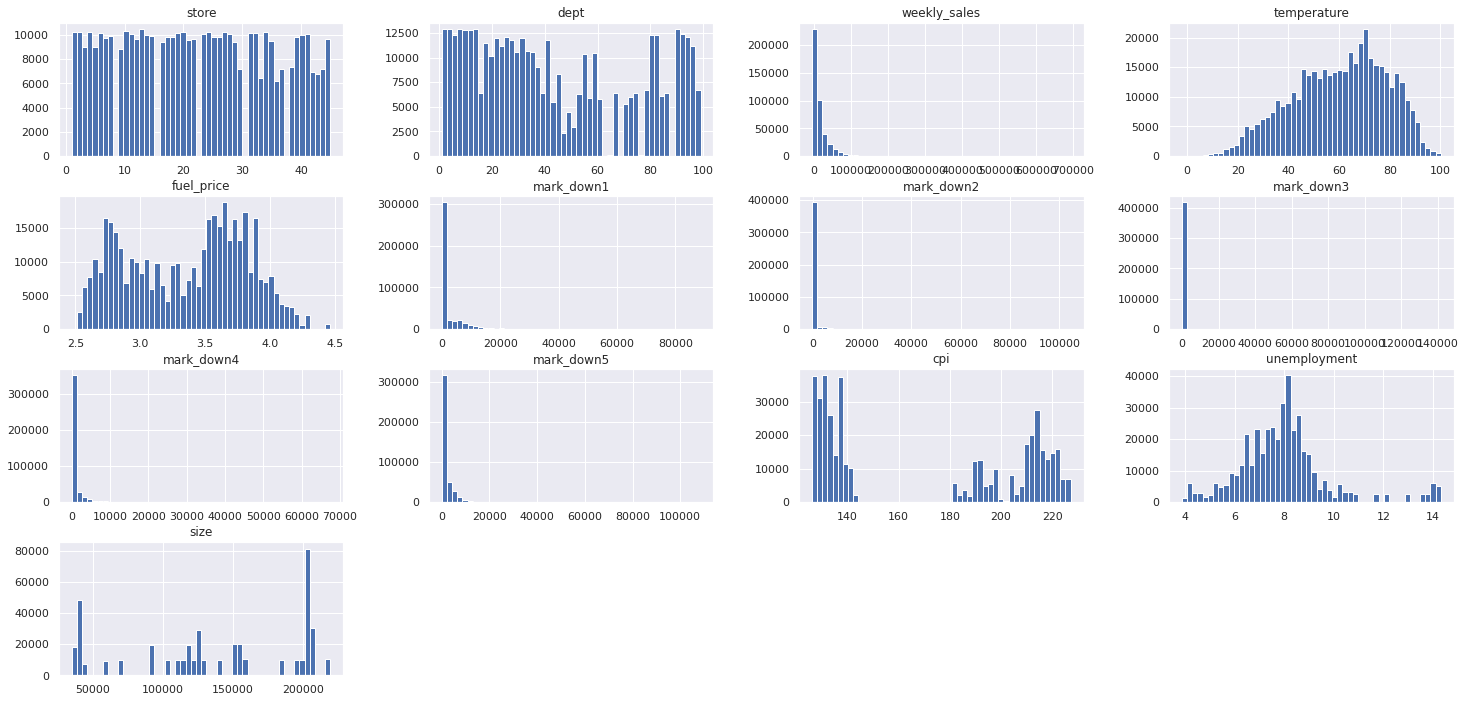

In [24]:
# check numerical features distribution
num_attributes.hist(bins = 50);

- histograms were take into account to check how features distributions behave

#### 5.7.2 Categorical Attributes

In [25]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

type    3
dtype: int64

In [26]:
cate_attributes.type.value_counts()

A    215478
B    163495
C     42597
Name: type, dtype: int64

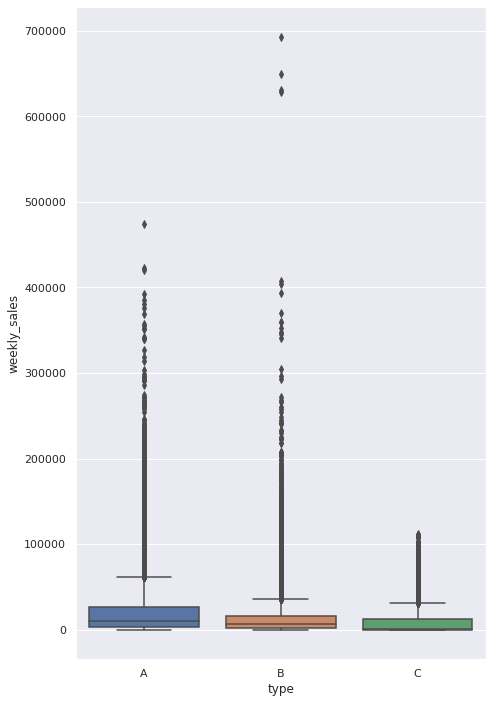

In [27]:
# plot boxplots of categorical features against target variable
aux1 = df1[(df1['type'] != '0') & (df1['weekly_sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='type', y= 'weekly_sales', data=aux1);

- A boxplot is a graph that gives you a good indication of how the values in the data are spread out
- boxplots may seem primitive in comparison to a histogram or density plot, they have the advantage of taking up less space, which is useful when comparing distributions between many groups or datasets.

## 6 FEATURE ENGINEERING
<a id="section-six"></a>

- in this sessions we created a hypothese mindmap to help us to create hipothesis and after that feature engineering

In [11]:
df2 = df1.copy()

### 6.1 Hypothesis Mindmap

Created based on what affects the business problem:

1) Phenomeno: What phenomenon am I modeling?

2) Agents: Who are the agents that act on the phenomenon of interest? (all entities that impact the phenomenon)

3) Agent attributes: what is the description of the agents? (ex: client is age, salary, profession, etc.)

4) List of Hypotheses: Hypotheses to validate with the data


- insights are generated in two ways: surprise and belief contravention
- Hypotheses are bets, they must be written as a statement in relation to the response variable.
- It is not a cause and effect relationship, but a correlation

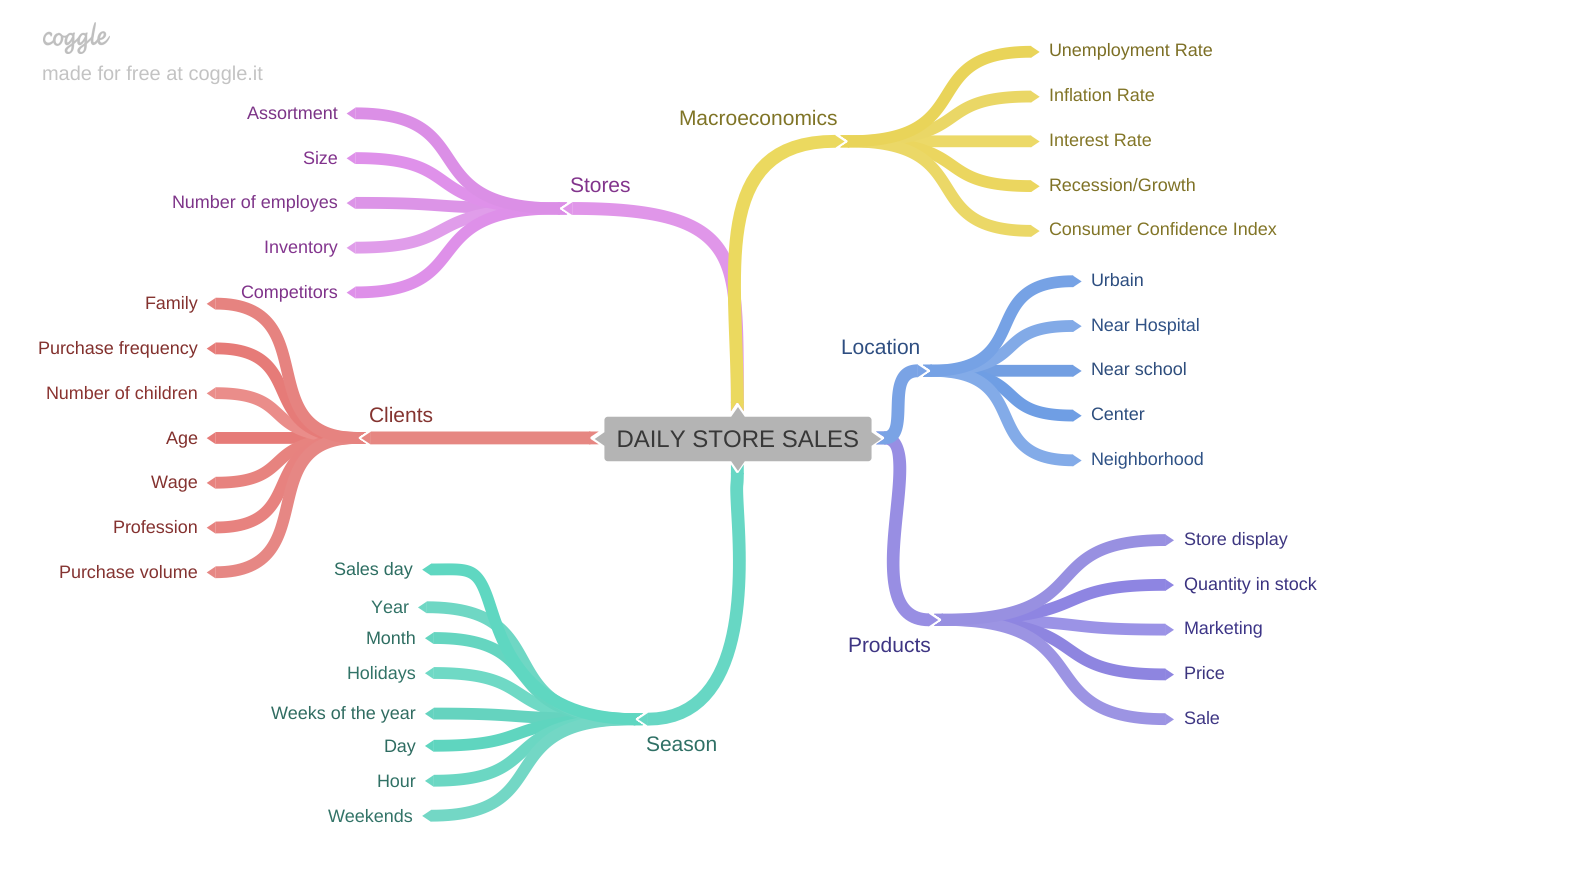

In [30]:
# Hypothesis Mindmap to help us to create business hypothesis
Image(home_path + '/src/img/DAILY_STORE_SALES.png')

### 6.2 Creating Hypothesis

#### 6.2.1 Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with larger assortments should sell more.

**5.** Type A stores should sell more

**6.** Stores with more departments should sell more

#### 6.2.2 Product Hypothesis 

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with longer active promotions should sell more.

#### 6.2.3 Time Hypothesis

**1.** Stores during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 2nd week each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell more during holidays.

#### 6.2.4 Macroeconomics

**1.** Places with lower temperatures sell more

**2.** Locations with lower gas prices sell more.

**3.** Places with higher unemployment rate sell less

**4.** Places with a high consumer confidence index sell more

### 6.3 Final Hypothesis List

In [31]:
# Prioritization based on available features in the dataset

**1.** Larger stores should sell more.

**2.** Type A stores should sell more.

**3.** Stores with more departments should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more. (markdows)

**5.** Stores during the Christmas holiday should sell more.

**6.** Stores should sell more over the years.

**7.** Stores should sell more in the second half of the year.

**8.** Stores should sell more after the 2nd week each month.

**9.** Places with lower temperatures sell more

**10.** Locations with lower gas prices sell more.

**11.** Places with higher unemployment rate sell less

**12.** Places with a high consumer confidence index sell more

### 6.4 Feature Engineering

In [12]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# year quarter
df2['quarter'] = df2['date'].dt.to_period('Q')

## 7 VARIABLE FILTERING 
<a id="section-seven"></a>

In [13]:
 df3 = df2.copy()

the motivation behind variable filtering is business constraints

### 7.1 Rows Filtering

- Firstly I do the rows filtering because it reduces the dataset volume, increasing the processing performance;
- We are removing weekly sales with negative values since it will not increase the bias of the model that much;
- During the next CRISP cicle we can work on negative sales and ask the business teams for some business constraints

In [15]:
# checking the impact of removing negative sales
# percentage of register that we will deleted with this action
df3[df3['weekly_sales']< 0].shape[0]/df3.shape[0] * 100

0.30481296107408024

In [35]:
# checking the impact of removing negative sales
df3[df3['weekly_sales']< 0]['weekly_sales'].sum()

-88161.56

In [85]:
# checking the impact of removing negative sales
df3[df3['weekly_sales']< 1]['weekly_sales'].sum()

239.99

In [36]:
df3[df3['weekly_sales']>= 0]['weekly_sales'].sum()

6737307148.669999

In [37]:
88161.56/6737307148.67 * 100

0.0013085578266593325

In [14]:
df3 = df3[df3['weekly_sales']>= 1]

## 8 EXPLORATORY DATA ANALYSIS (EDA)
<a id="section-eight"></a>

How do the variables impact the phenomenon, in this case weekly sales?

How strong is this impact?

It serves to measure the impact of features in relation to the response variable (target)

3 goals:
- gain business experience
- validate business hypotheses (insights)
- elect variables that are important to the model

In [15]:
df4 = df3.copy()

### 8.1 Univariate Analysis

#### 8.1.1 Response Variable (target)

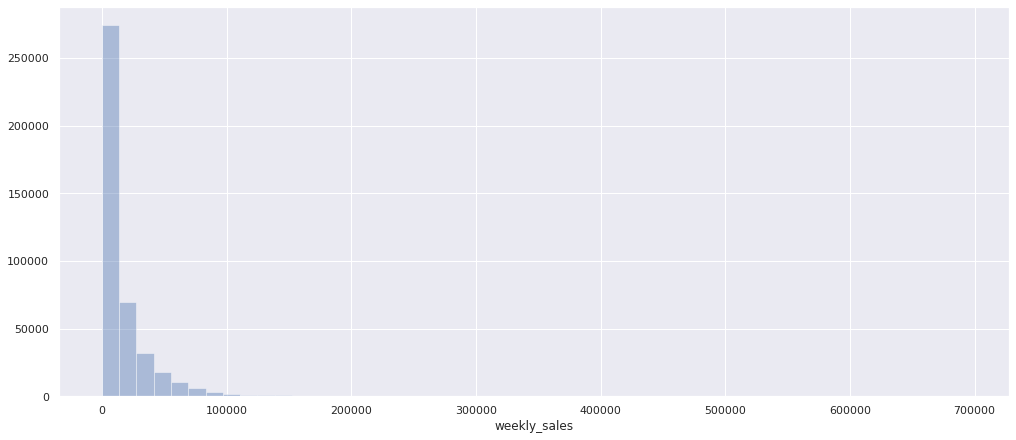

In [18]:
# plot target variable distribution
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['weekly_sales'], kde = False);
plt.style.use('tableau-colorblind10');

- It is not close to a normal distribution. 
- Skew far to the right.
- The more normal the response variable, the better the algorithm will perform. We might have to use log transformation later on it

#### 8.1.2 Numerical Variable

In [19]:
num_attributes = df4.select_dtypes( include = 'number')

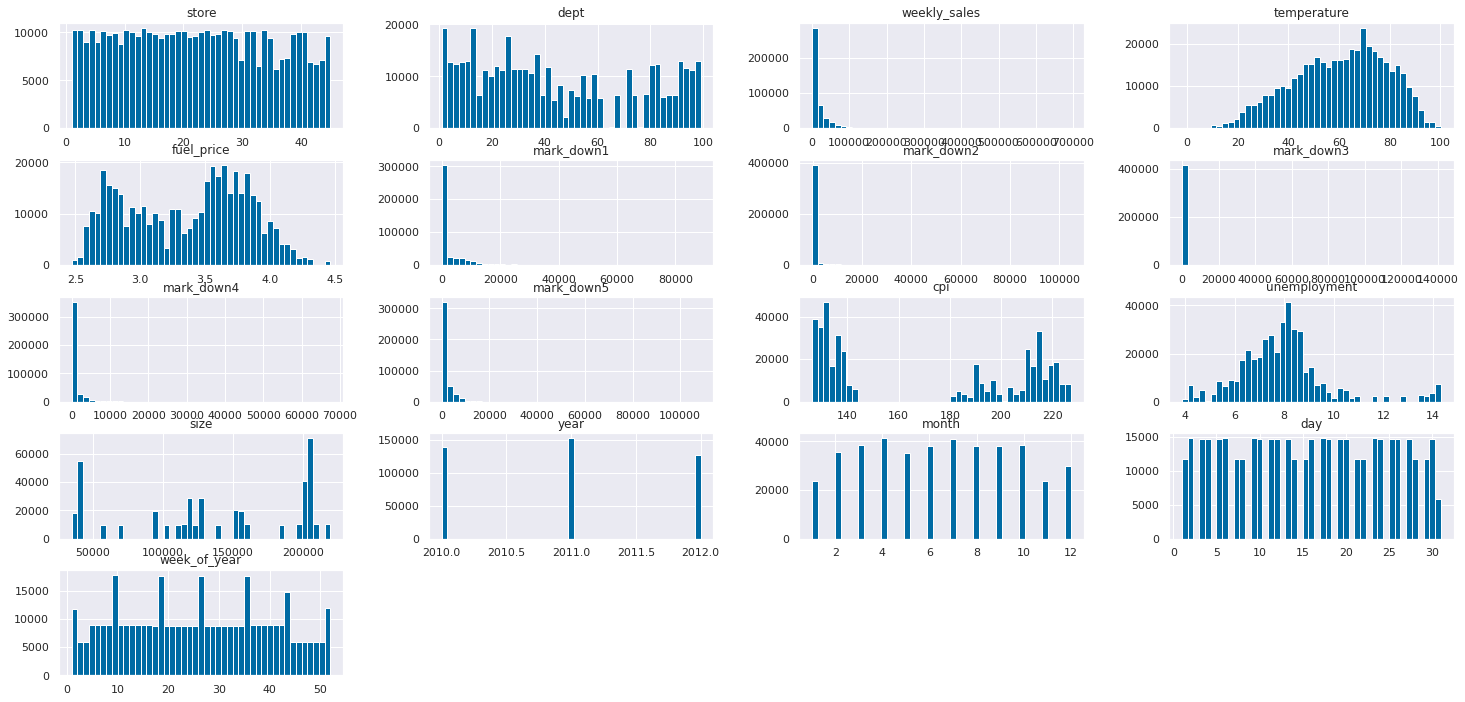

In [20]:
# histogram for numerical features
num_attributes.hist(bins = 45);
plt.style.use('tableau-colorblind10');

In [43]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

attributes        min            max          range           mean         median           std       skew    kurtosis
0          store      1.000      45.000000      44.000000      22.195477      22.000000     12.787198   0.077998   -1.146661
1           dept      1.000      99.000000      98.000000      44.242771      37.000000     30.507160   0.358929   -1.216545
2   weekly_sales      0.000  693099.360000  693099.360000   16030.329773    7659.090000  22728.473109   3.259109   21.462455
3    temperature     -2.060     100.140000     102.200000      60.090474      62.090000     18.448238  -0.321260   -0.636254
4     fuel_price      2.472       4.468000       1.996000       3.360888       3.452000      0.458522  -0.104657   -1.185467
5     mark_down1      0.000   88646.760000   88646.760000    2590.187246       0.000000   6053.218298   4.730880   34.911833
6     mark_down2   -265.760  104519.540000  104785.300000     878.803239       0.000000   5076.519195  10.650041  145.590579
7     mark_down3    -29.100  141630.610000  141659.710000     468.771234       0.000000   5533.586529  14.910194  247.691160
8     mark_down4      0.000   67474.850000   67474.850000    1083.462694       0.000000   3895.796878   8.075474   86.198553
9     mark_down5      0.000  108519.280000  108519.280000    1662.706138       0.000000   4205.941637   9.952345  183.096139
10           cpi    126.064     227.232807     101.168807     171.212152     182.350989     39.162233   0.084679   -1.829840
11  unemployment      3.879      14.313000      10.434000       7.960077       7.866000      1.863871   1.183844    2.729313
12          size  34875.000  219622.000000  184747.000000  136749.569176  140167.000000  60992.616007  -0.326675   -1.206389
13          year   2010.000    2012.000000       2.000000    2010.968443    2011.000000      0.796892   0.056504   -1.423283
14         month      1.000      12.000000      11.000000       6.449709       6.000000      3.243390   0.040575   -1.110862
15           day      1.000      31.000000      30.000000      15.673919      16.000000      8.752814   0.009127   -1.198702
16  week_of_year      1.000      52.000000      51.000000      25.827729      26.000000     14.152425   0.052415   -1.112175

**Overall:** All variables don't follow a normal distribution

 - Store: There are specific stores that have less weekly sales points than others;
 - dept: There are specific departaments that have less weekly sales points than others;
 - temperature: THe closest to a normal distribuition, a little skewed to the left (-)
 - week_of_year: some especifics weeks have more sales data points
 - month: more sales data points in months 4 and 7
 - year: more sales data points in the year 2011

#### 8.1.3 Categorical Variable

In [21]:
cate_attributes = df4.select_dtypes( include = 'object')

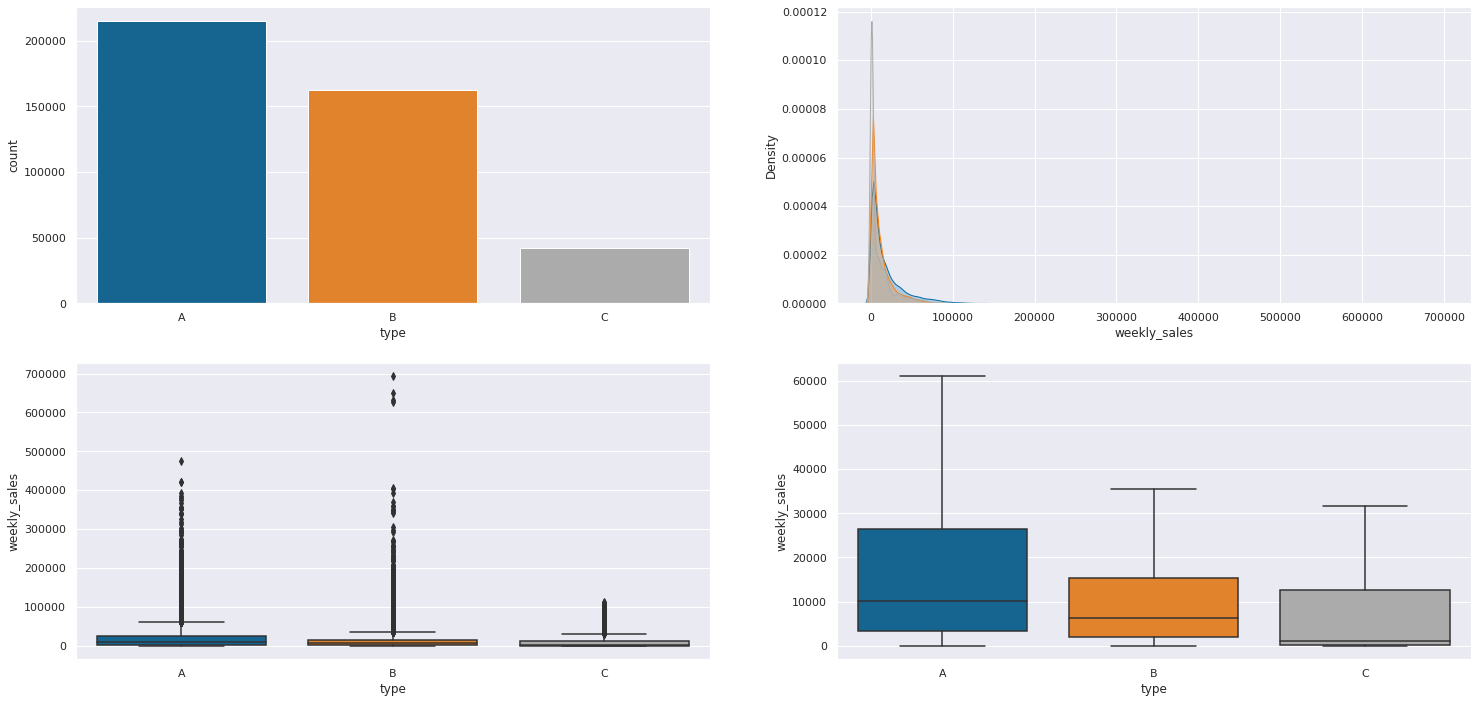

In [45]:
# type
plt.subplot(2, 2, 1)
sns.countplot(data = df4, x = df4['type'])

plt.subplot(2, 2, 2)
sns.kdeplot(data = df4, x = df4[df4['type'] == 'A']['weekly_sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['type'] == 'B']['weekly_sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['type'] == 'C']['weekly_sales'], shade = True);

plt.subplot(2, 2, 3)
sns.boxplot(x='type', y= 'weekly_sales', data=df4);

plt.subplot(2, 2, 4)
sns.boxplot(x='type', y= 'weekly_sales', data=df4, showfliers=False);
plt.style.use('tableau-colorblind10');

- More sales datapoint in stores of type A
- Little contribution of the types of stores in relation to the response variable, since the distributions are overlapped.
- The median of A is the highest and C is the lowest

### 8.2 Bivariate Analysis

#### H1. Larger stores should sell more.

**TRUE** Stores with more sizes have higher sales record

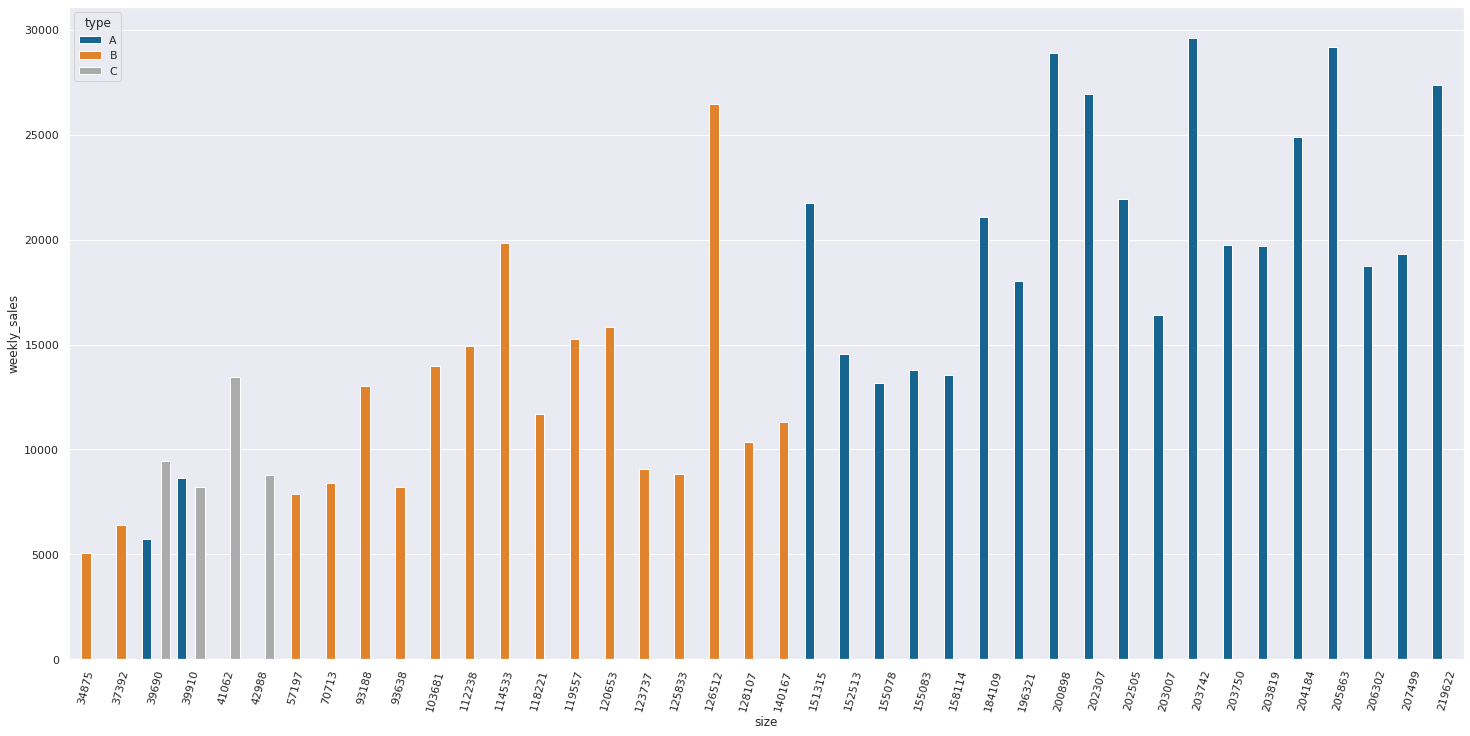

In [46]:
# compare the size and type of store with weekly sales
aux = df4[['weekly_sales', 'type', 'size']].groupby(['type', 'size']).mean().reset_index()

sns.barplot(x = 'size', y = 'weekly_sales', data = aux, hue = 'type')
plt.xticks(rotation = 75);
plt.style.use('tableau-colorblind10');

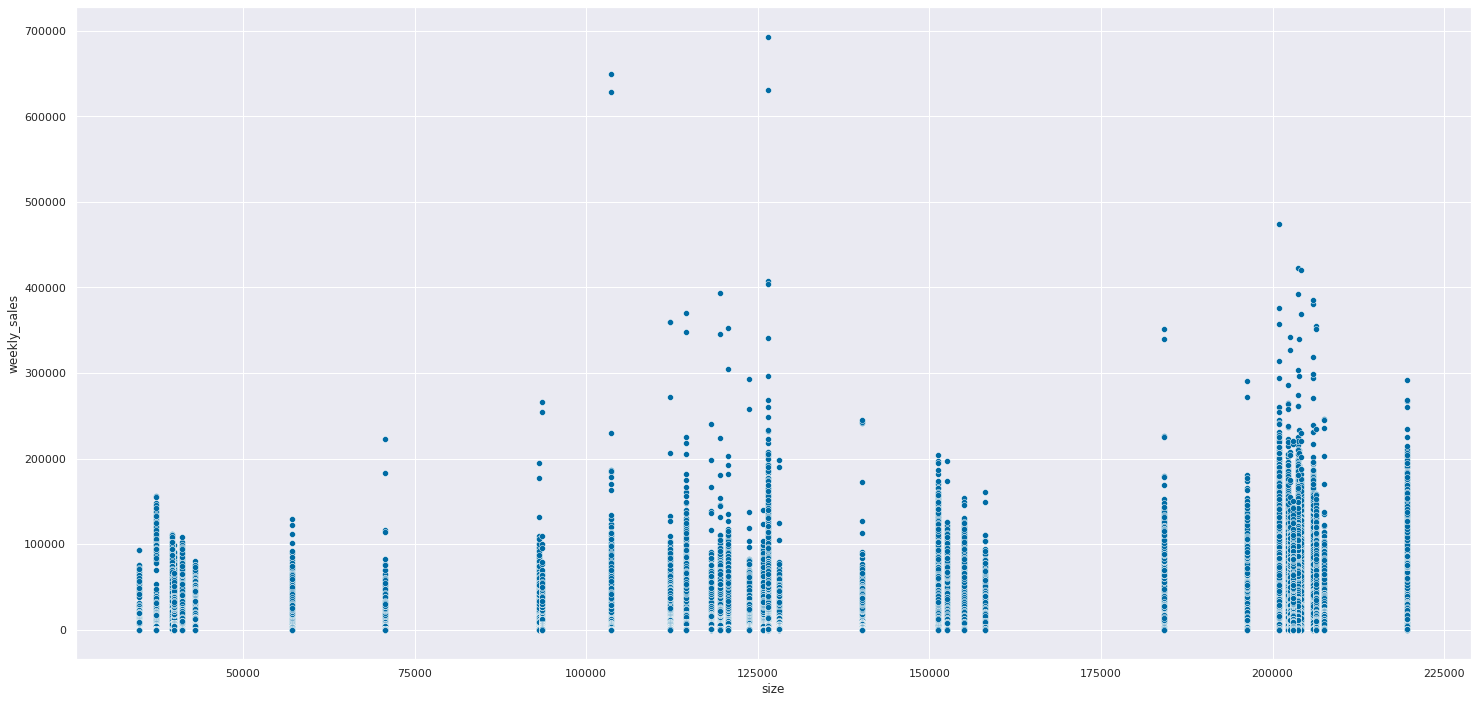

In [47]:
# scatterplot from df4
sns.scatterplot(df4['size'], df4['weekly_sales']);

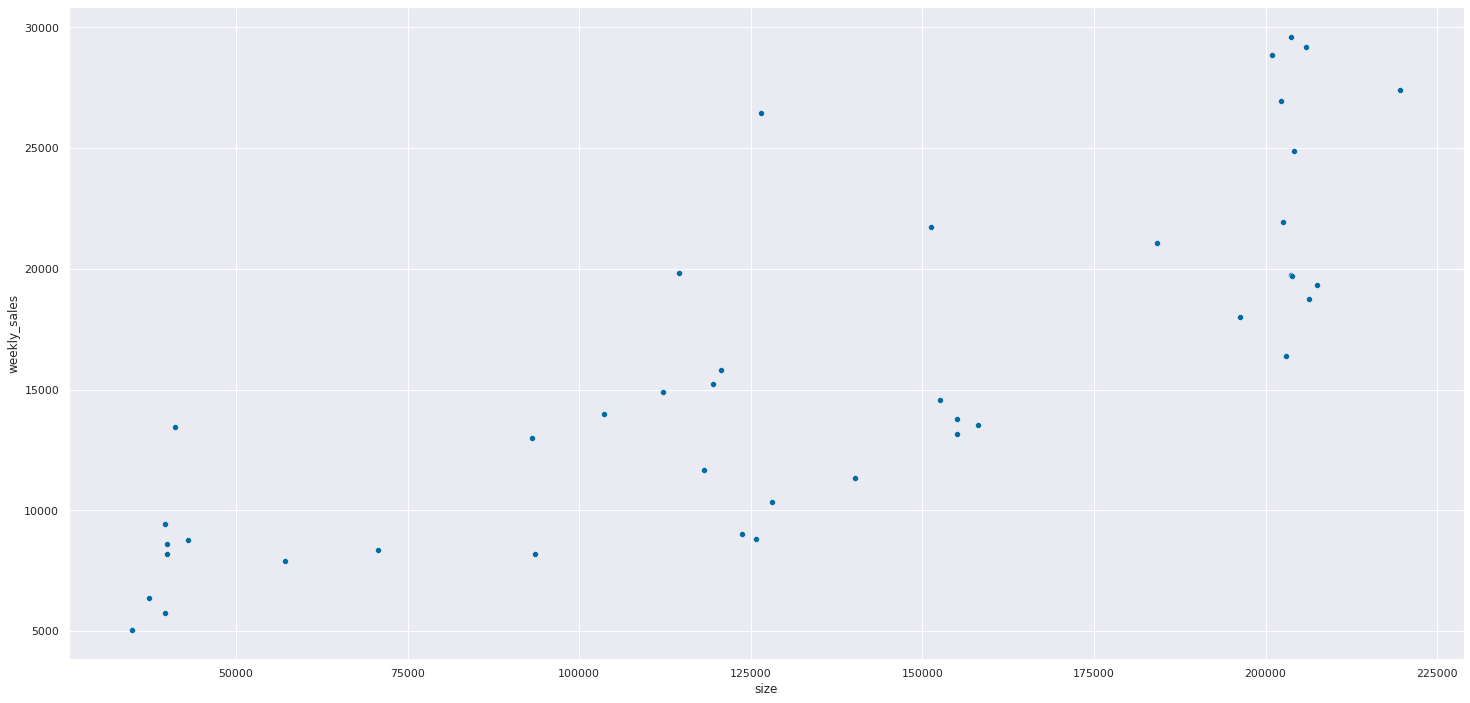

In [48]:
# scatterplot aggregated sizes
sns.scatterplot(aux['size'], aux['weekly_sales']);

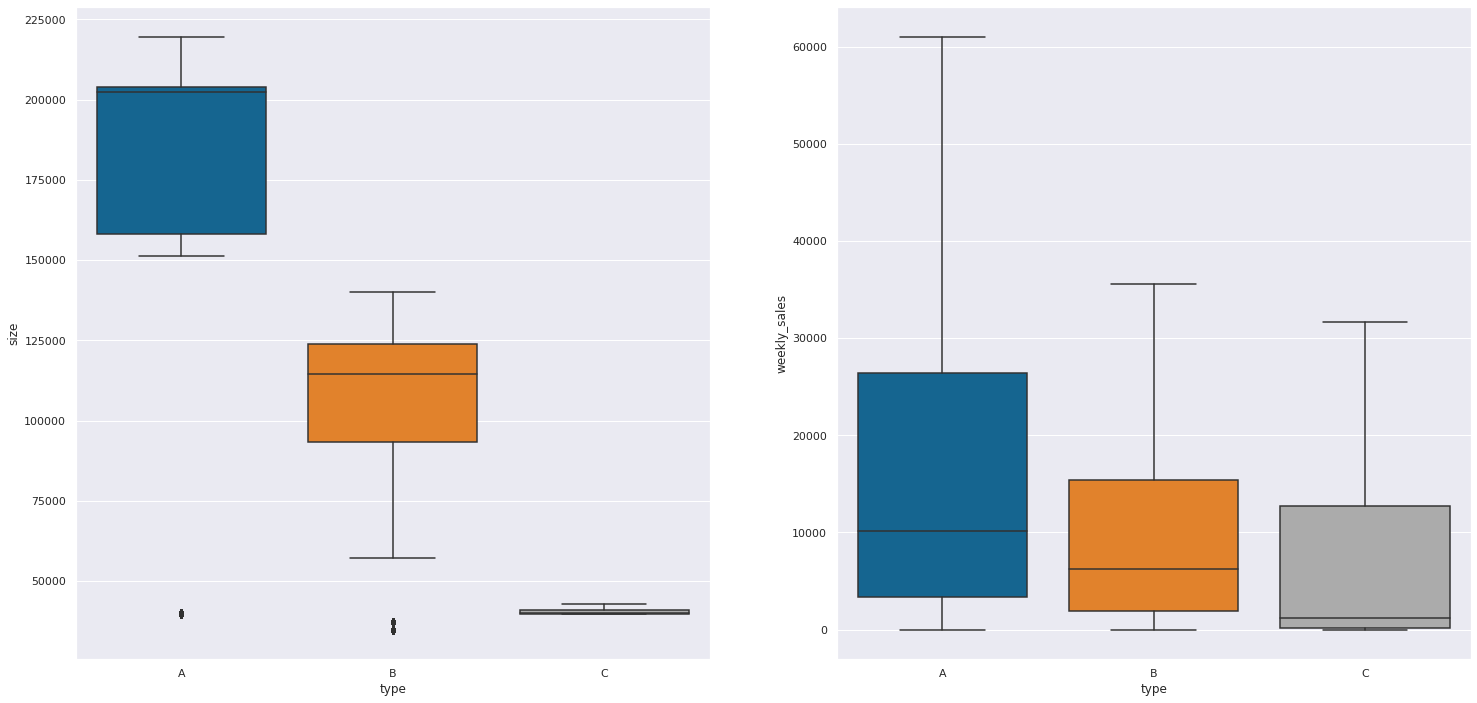

In [49]:
# type and size boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='type', y='size', data=df4)
plt.style.use('tableau-colorblind10');

plt.subplot(1, 2, 2)
sns.boxplot(x='type', y= 'weekly_sales', data=df4, showfliers=False);
plt.style.use('tableau-colorblind10');

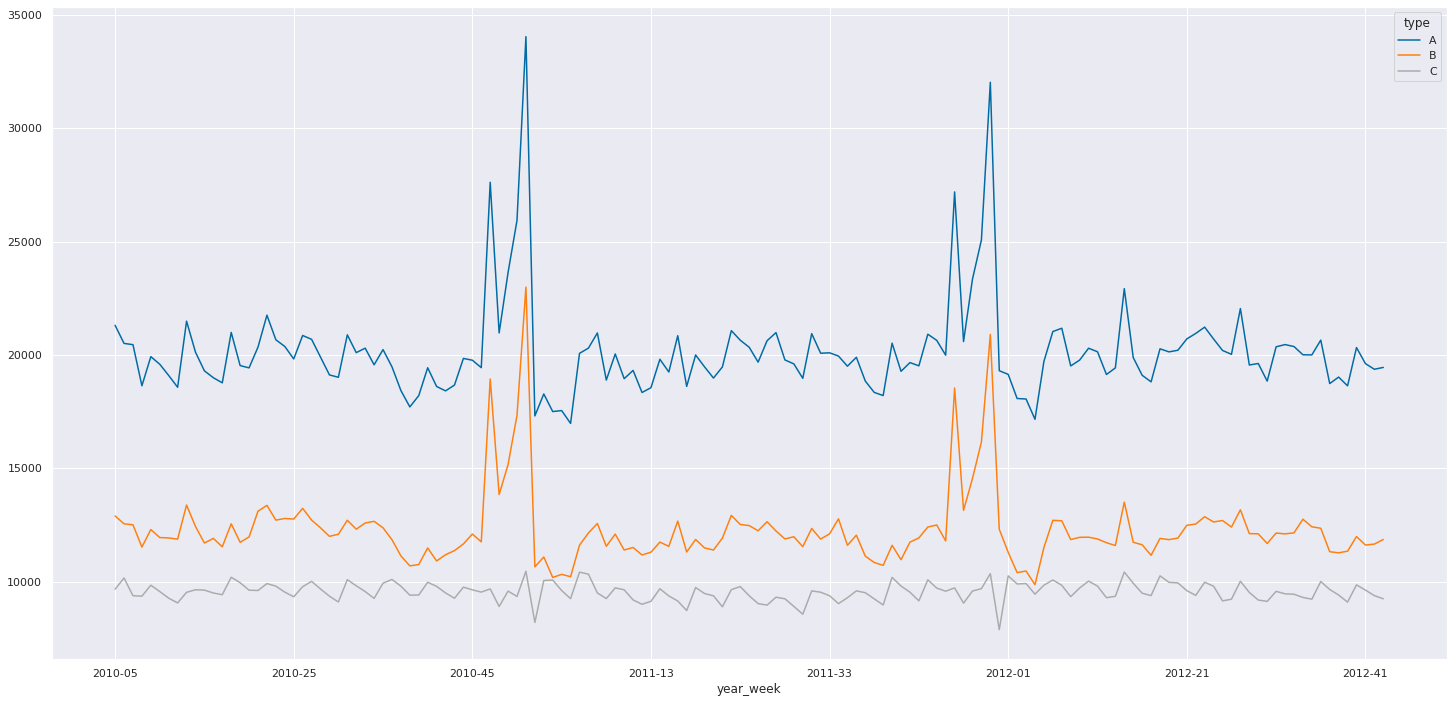

In [50]:
#check how different type stores performed over years
aux2 = df4[['weekly_sales', 'type', 'year_week']].groupby(['type', 'year_week']).mean().reset_index()
aux2.pivot( index = 'year_week', columns = 'type', values = 'weekly_sales').plot();


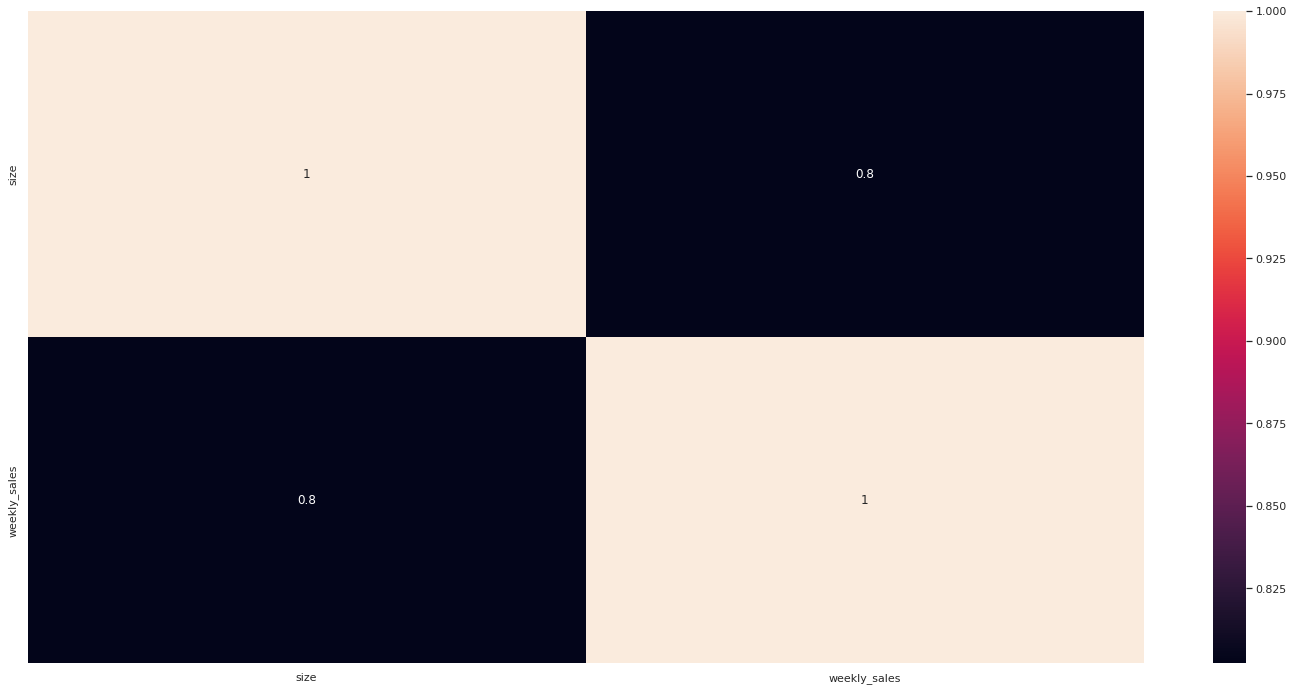

In [51]:
# correlation between size and weekly sales
sns.heatmap(aux.corr(method= 'pearson'), annot= True);

- By boxplot, we can infer that type A store is the largest store and C is the smallest
- There is no overlapped area in size among A, B, and C. Type is the best predictor for Size
- Stores with more sizes have higher sales record (The order of median of size and median of sales is the same)

#### H2. Type A stores should sell more.
**TRUE** Type A Stores sell more over time, but because they are strongly correlated with size (hypothersis number 1)

#### H3. Stores with more departments should sell more.
**TRUE** Stores with more department tend to sell more.

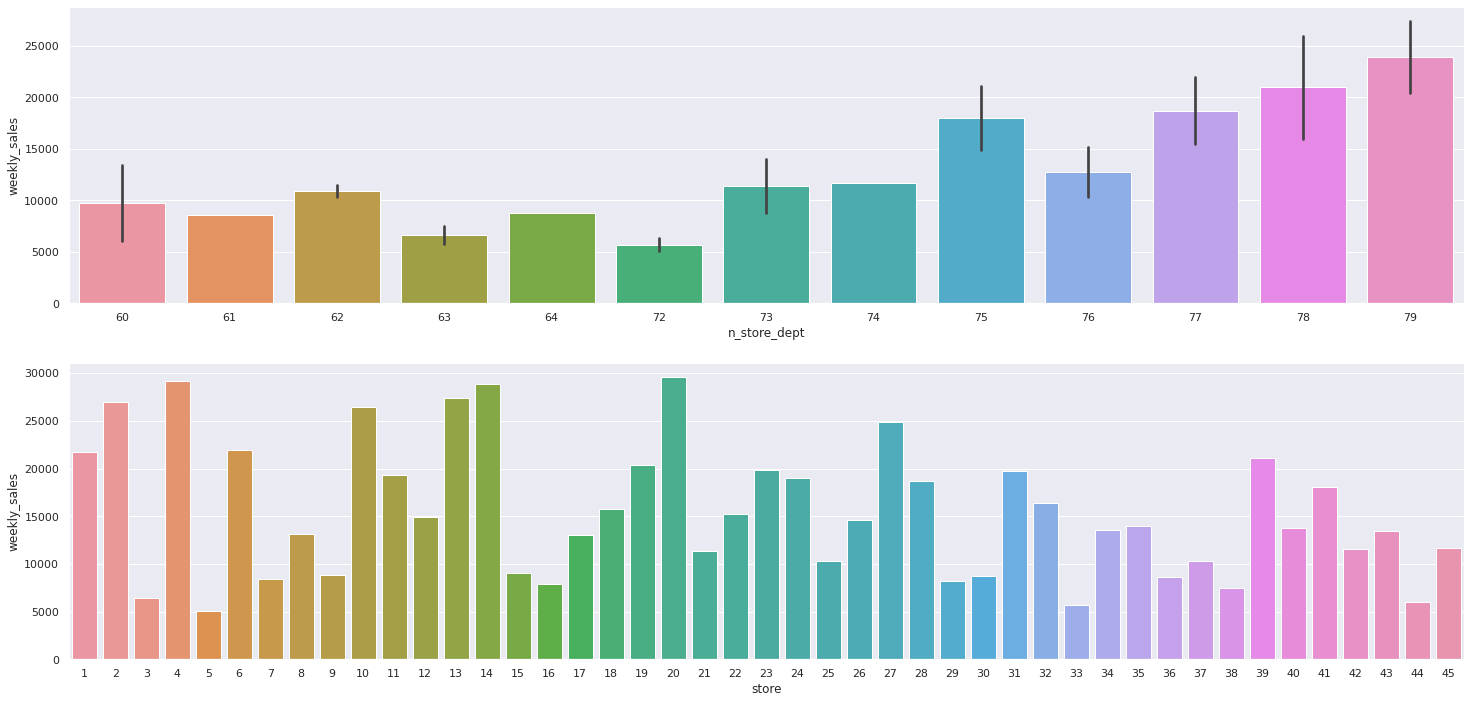

In [52]:
# compare the number of departments of each store with weekly sales
aux = df4[['store', 'dept', 'weekly_sales']].groupby(['store']).agg(n_store_dept = ('dept', 'nunique'),
                                                                    weekly_sales = ('weekly_sales', 'mean')).reset_index()

# compare the store number with weekly sales
aux2 = df4[['store', 'weekly_sales']].groupby(['store']).mean().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x= 'n_store_dept', y= 'weekly_sales', data= aux);
plt.style.use('tableau-colorblind10');

plt.subplot(2, 1, 2)
sns.barplot(x= 'store', y= 'weekly_sales', data= aux2);
plt.style.use('tableau-colorblind10');

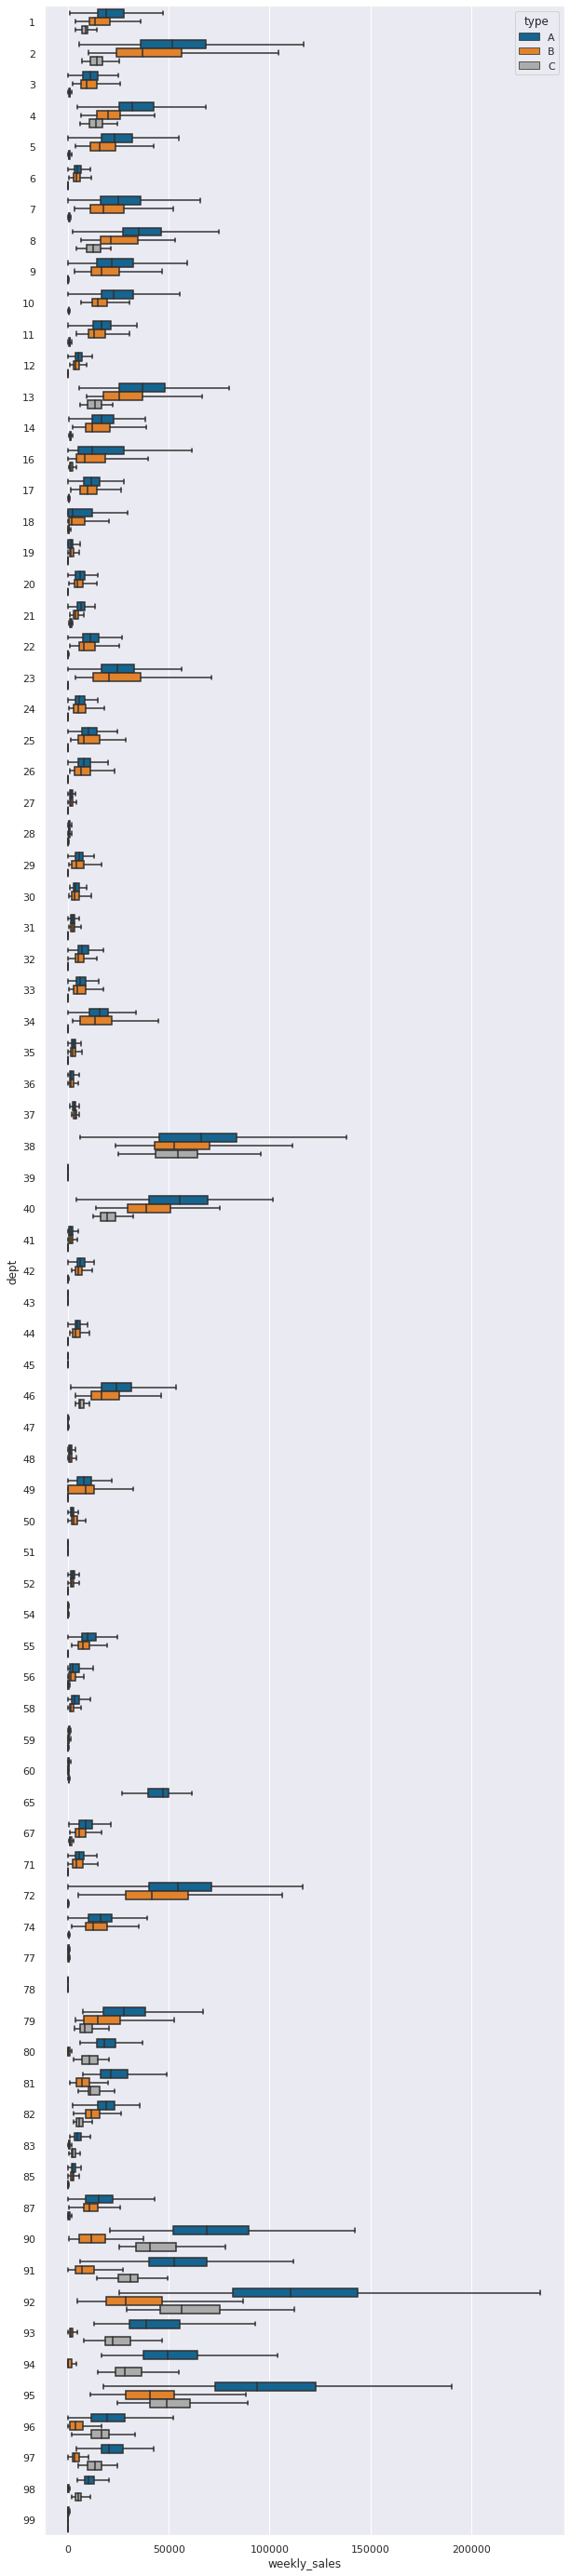

In [53]:
# checking each department individualy by type
f, ax = plt.subplots(figsize=(10, 50))
sns.boxplot(x='weekly_sales', y= 'dept', data=df4, showfliers=False, hue="type",orient="h");
plt.style.use('tableau-colorblind10');

- Each department shows the different level of sales
- Department may be the powerful variable to predict sales
- When department and type of store are considered together, generally department in A type shows the highest sales record
- Type and department may have the interaction effect
- There are missing some departaments (eg: 15, 73..)

#### H4. Stores with more aggressive promotions (bigger discounts) should sell more. (markdows)

**FALSE** Not very clear the influence of markdows in the weekly sales. Next CRISP cycle we will do a more in-depth analysis


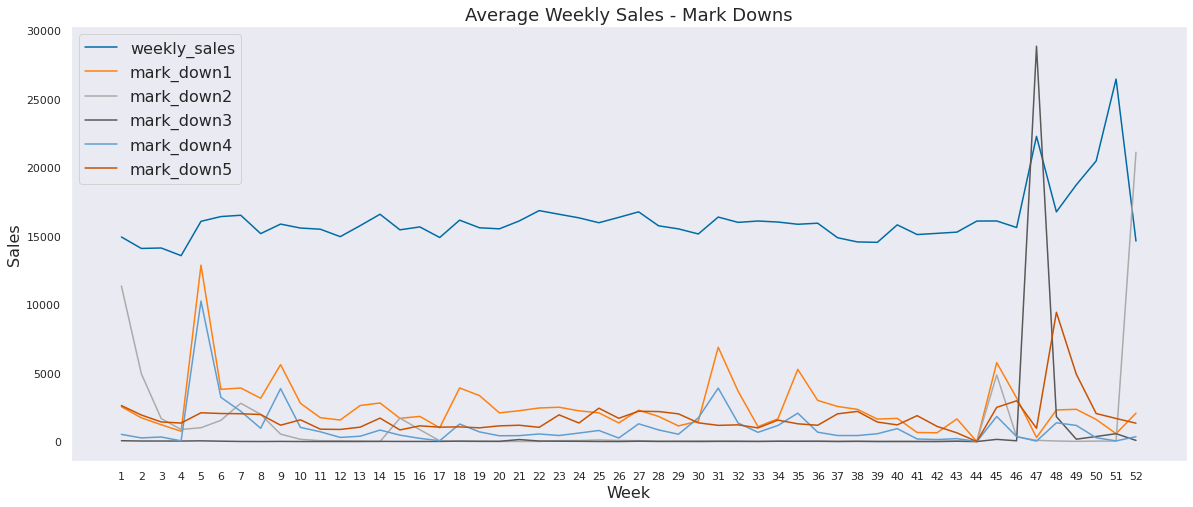

In [54]:
# compare weekly sales with all mark downs features
aux = df4[['weekly_sales', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5']].groupby(df4['week_of_year']).mean()

plt.figure(figsize=(20,8))

sns.lineplot(aux.index, aux.weekly_sales.values)
sns.lineplot(aux.index, aux.mark_down1.values)
sns.lineplot(aux.index, aux.mark_down2.values)
sns.lineplot(aux.index, aux.mark_down3.values)
sns.lineplot(aux.index, aux.mark_down4.values)
sns.lineplot(aux.index, aux.mark_down5.values)

plt.grid()

plt.xticks(np.arange(1, 53, step=1))
plt.legend(['weekly_sales', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Mark Downs', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

#### H5. Stores during the Christmas holiday week should sell more.
**TRUE** The highest point of weekly sales happen during the week 50 and 51

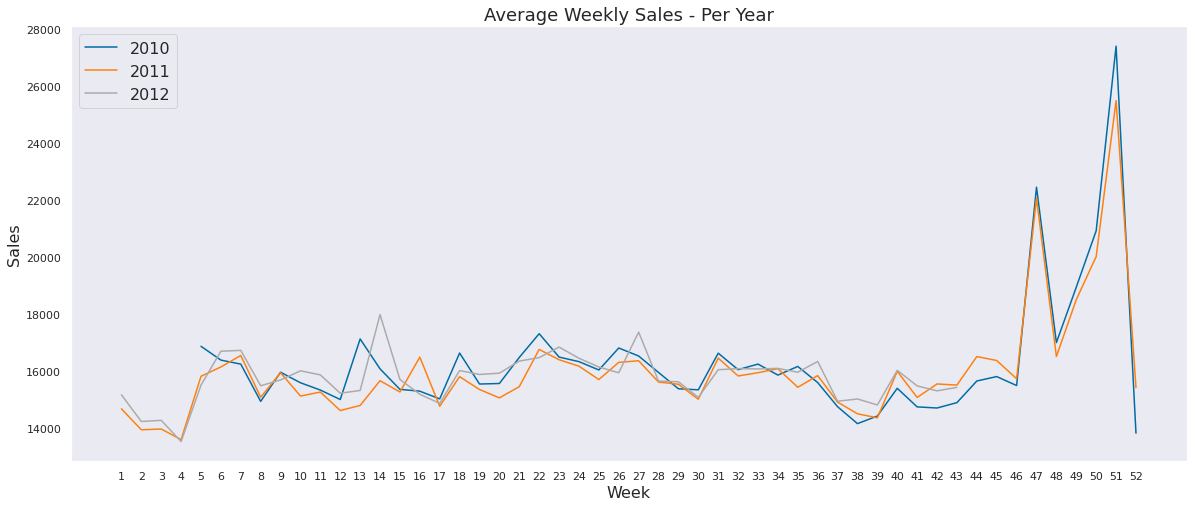

In [55]:
# plot sales week by week of the year for each year
weekly_sales_2010 = df4[df4['year']==2010]['weekly_sales'].groupby(df4['week_of_year']).mean()
weekly_sales_2011 = df4[df4['year']==2011]['weekly_sales'].groupby(df4['week_of_year']).mean()
weekly_sales_2012 = df4[df4['year']==2012]['weekly_sales'].groupby(df4['week_of_year']).mean()

plt.figure(figsize=(20,8))

sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)

plt.grid()

plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

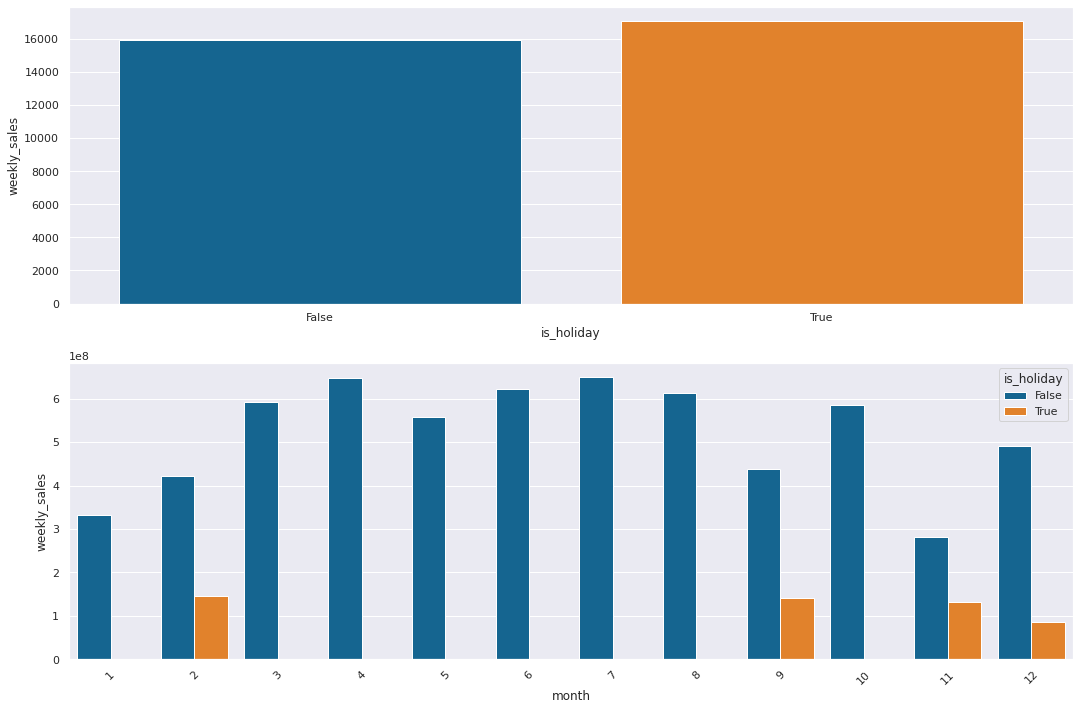

In [56]:
# compare weekly sales with holidays
aux = df4[['is_holiday', 'weekly_sales']].groupby('is_holiday').mean().reset_index();

fig = plt.figure(figsize = (18,12))
plt.subplot(211)
sns.barplot(data = aux, x= 'is_holiday', y= 'weekly_sales');

aux2 = df4[['month','is_holiday', 'weekly_sales']].groupby(['month','is_holiday']).sum().reset_index();

plt.subplot(212)
sns.barplot(data = aux2, x= 'month', y= 'weekly_sales', hue= 'is_holiday');
plt.xticks(rotation = 45);

- by thanksgiving and Christmas the sales rise up by a huge margin in all the years
- sales increase with holidays

#### H6. Stores should sell more over the years.
**FALSE** the weekly sales average is maintained over the years. However, it tends to decay a little but because 2012 christimas is not computed yet.

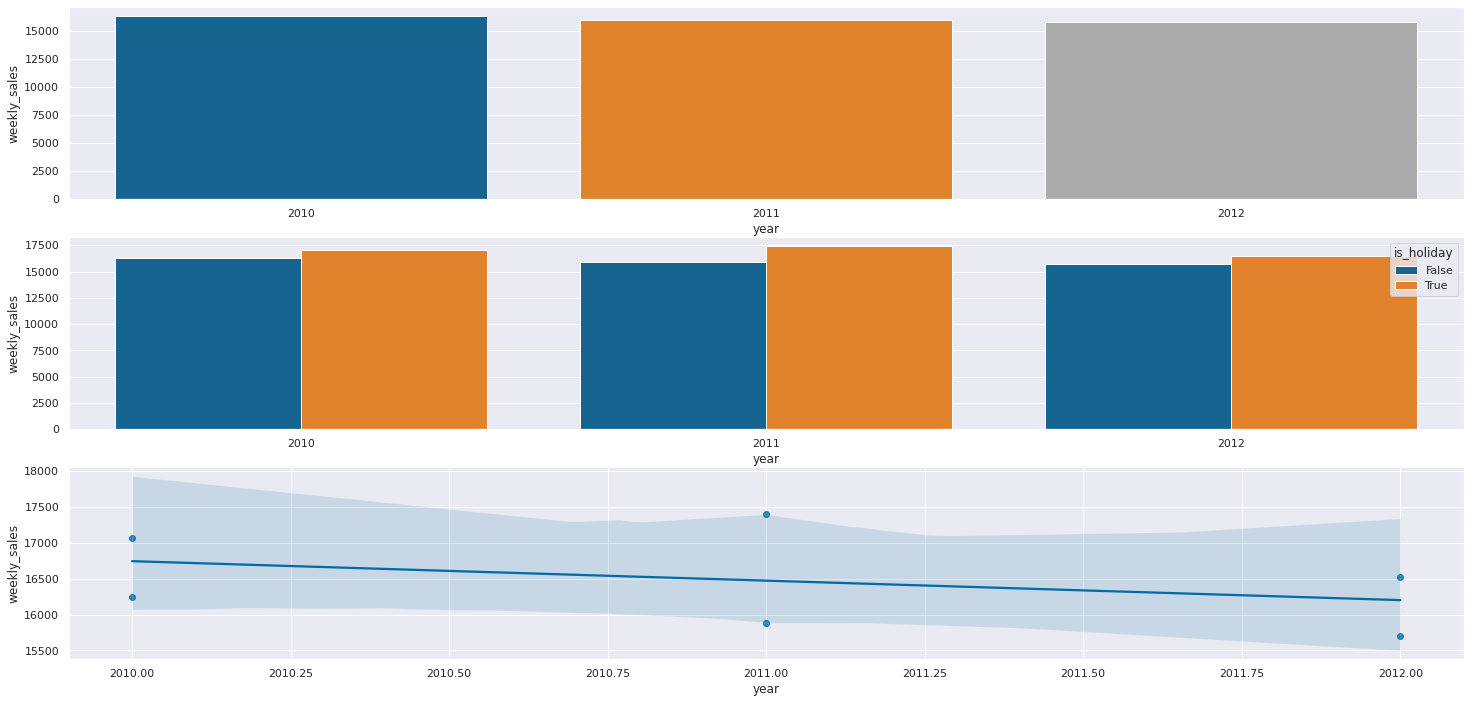

In [57]:
# average weekly sales over the years
aux  = df4[['year', 'is_holiday','weekly_sales']].groupby(['year', 'is_holiday']).mean().reset_index()
aux2 = df4[['year','weekly_sales']].groupby(['year']).mean().reset_index()

plt.subplot(3, 1, 1)
sns.barplot(data = aux2, x = 'year', y= 'weekly_sales');


plt.subplot(3, 1, 2)
sns.barplot(data = aux, x = 'year', y= 'weekly_sales', hue= 'is_holiday');

plt.subplot(3, 1, 3)
sns.regplot(data = aux, x= 'year', y= 'weekly_sales');

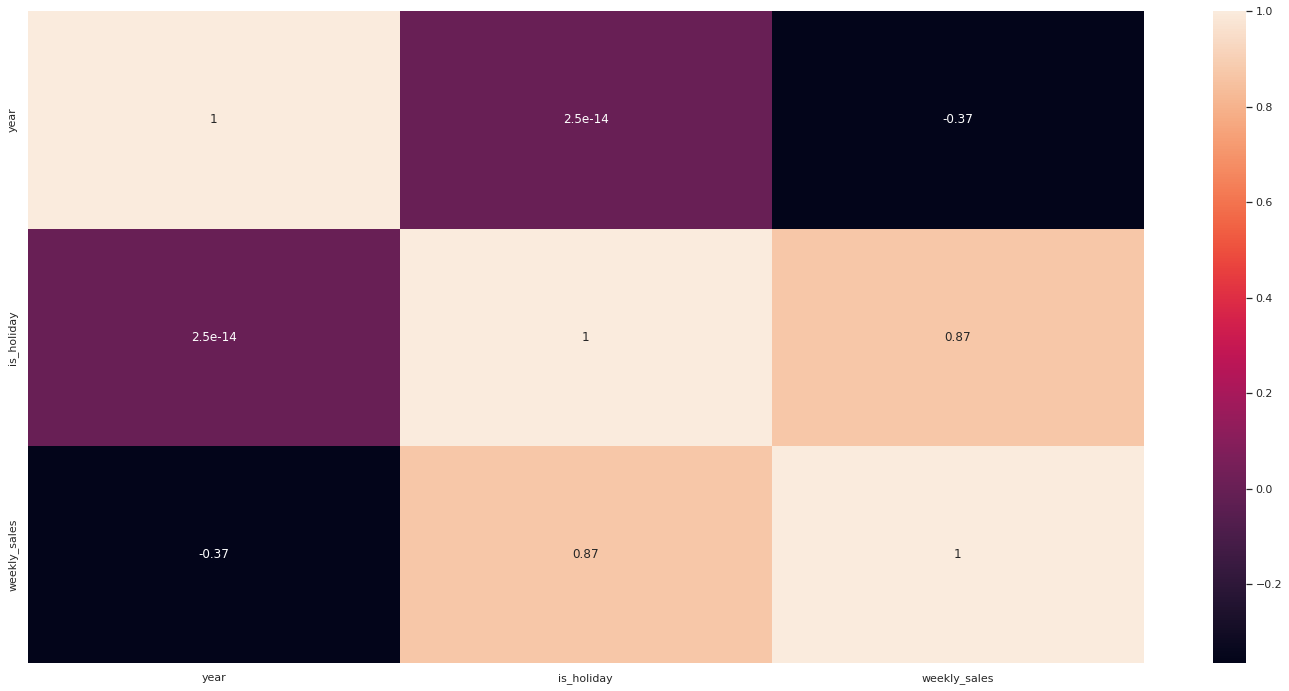

In [58]:
# correlation between year and weekly sales
sns.heatmap(aux.corr(method= 'pearson'), annot= True);

#### **H7.** Stores should sell more in the second half of the year.
**TRUE** Stores sell more in the second half of the year, mainly because of the last quarter which include thanks giving and christimas sales

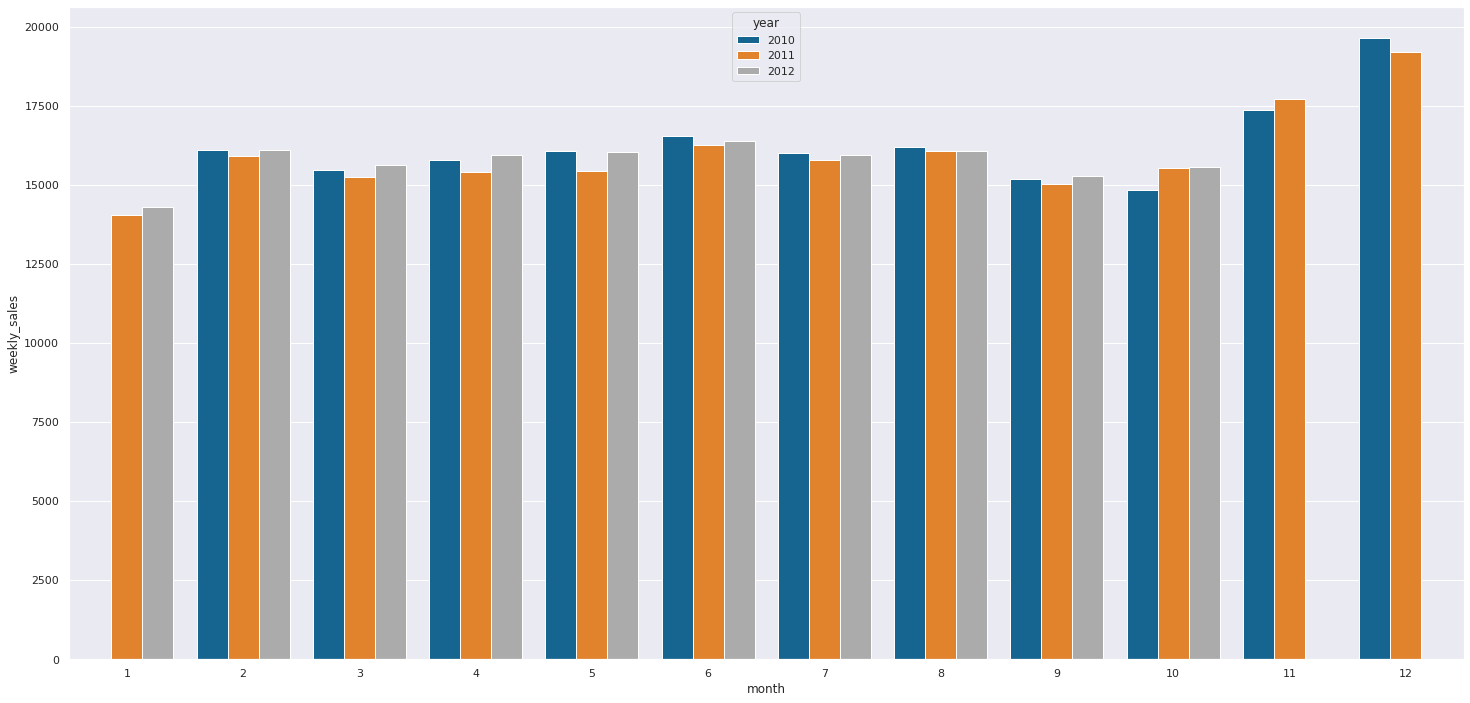

In [59]:
# month sales performance by year
aux = df4[['year', 'month','weekly_sales']].groupby(['year', 'month']).mean().reset_index()
sns.barplot(data = aux, x = 'month', y= 'weekly_sales', hue= 'year');

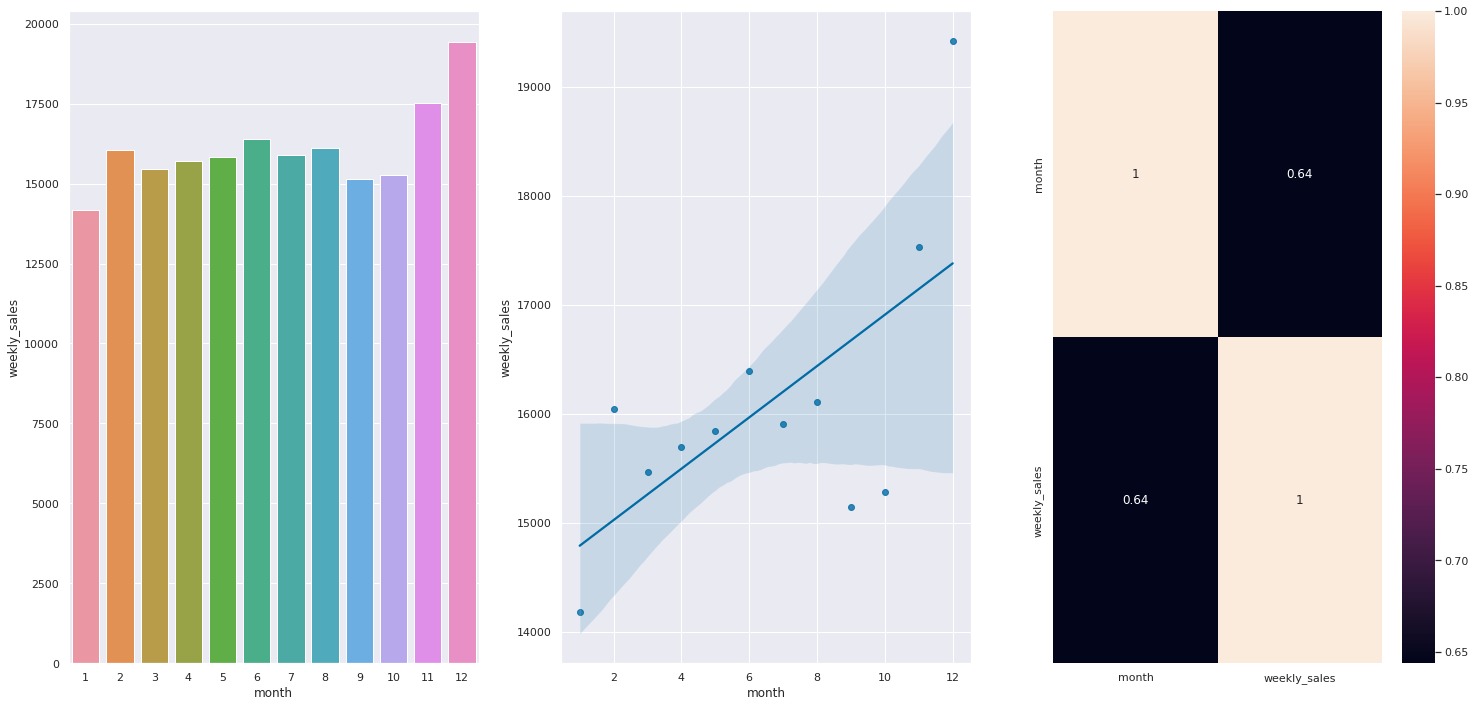

In [60]:
# aggregate month related to sales
plt.subplot(131)
aux = df4[['month','weekly_sales']].groupby(['month']).mean().reset_index()
sns.barplot(data = aux, x = 'month', y= 'weekly_sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'month', y= 'weekly_sales');

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

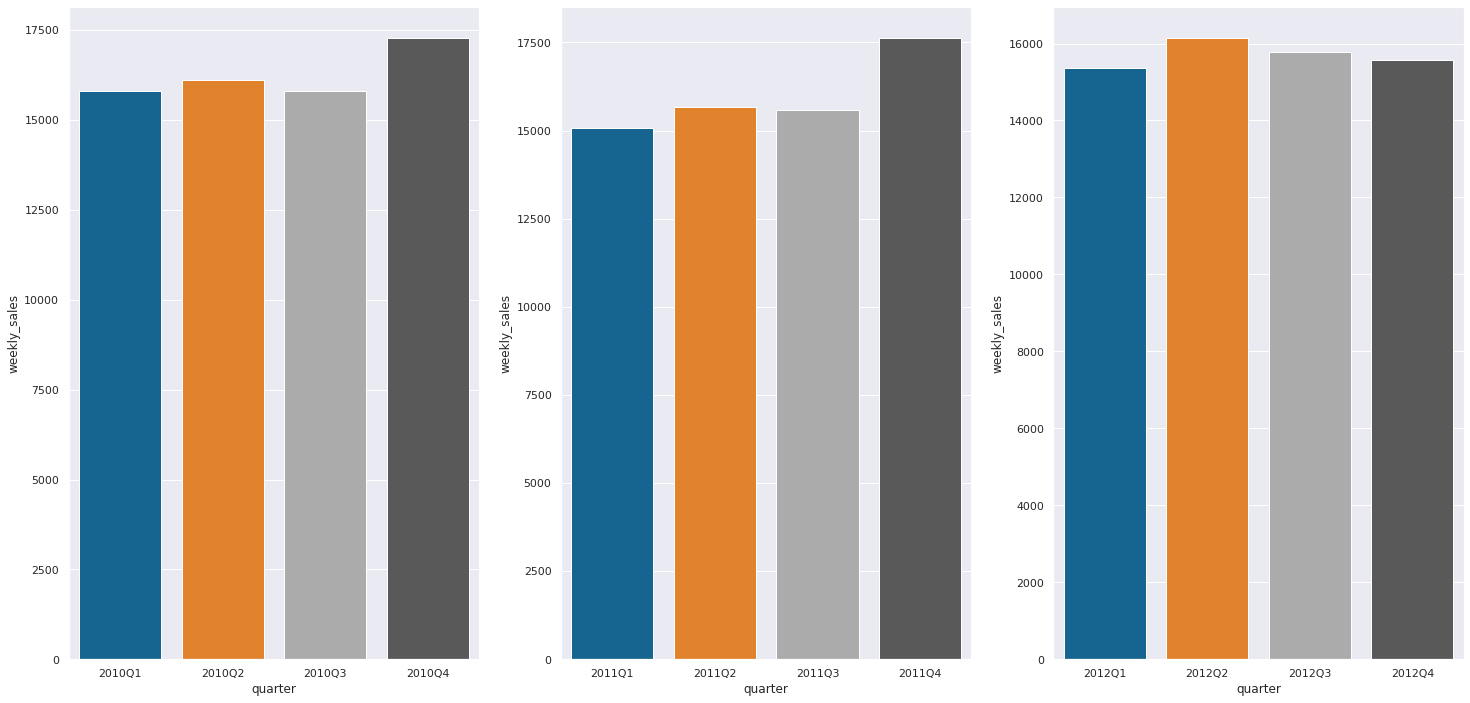

In [61]:
# sales performance by quarter
aux2010 = df4[df4['year']==2010][['weekly_sales', 'quarter']].groupby('quarter').mean().reset_index()
aux2011 = df4[df4['year']==2011][['weekly_sales', 'quarter']].groupby('quarter').mean().reset_index()
aux2012 = df4[df4['year']==2012][['weekly_sales', 'quarter']].groupby('quarter').mean().reset_index()

plt.subplot(131)
sns.barplot(data = aux2010, x = 'quarter', y = 'weekly_sales')
plt.subplot(132)
sns.barplot(data = aux2011, x = 'quarter', y = 'weekly_sales')
plt.subplot(133)
sns.barplot(data = aux2012, x = 'quarter', y = 'weekly_sales');

#### **H8.** Stores should sell more after the 2nd week each month.
**FALSE** Sales are almost the same.

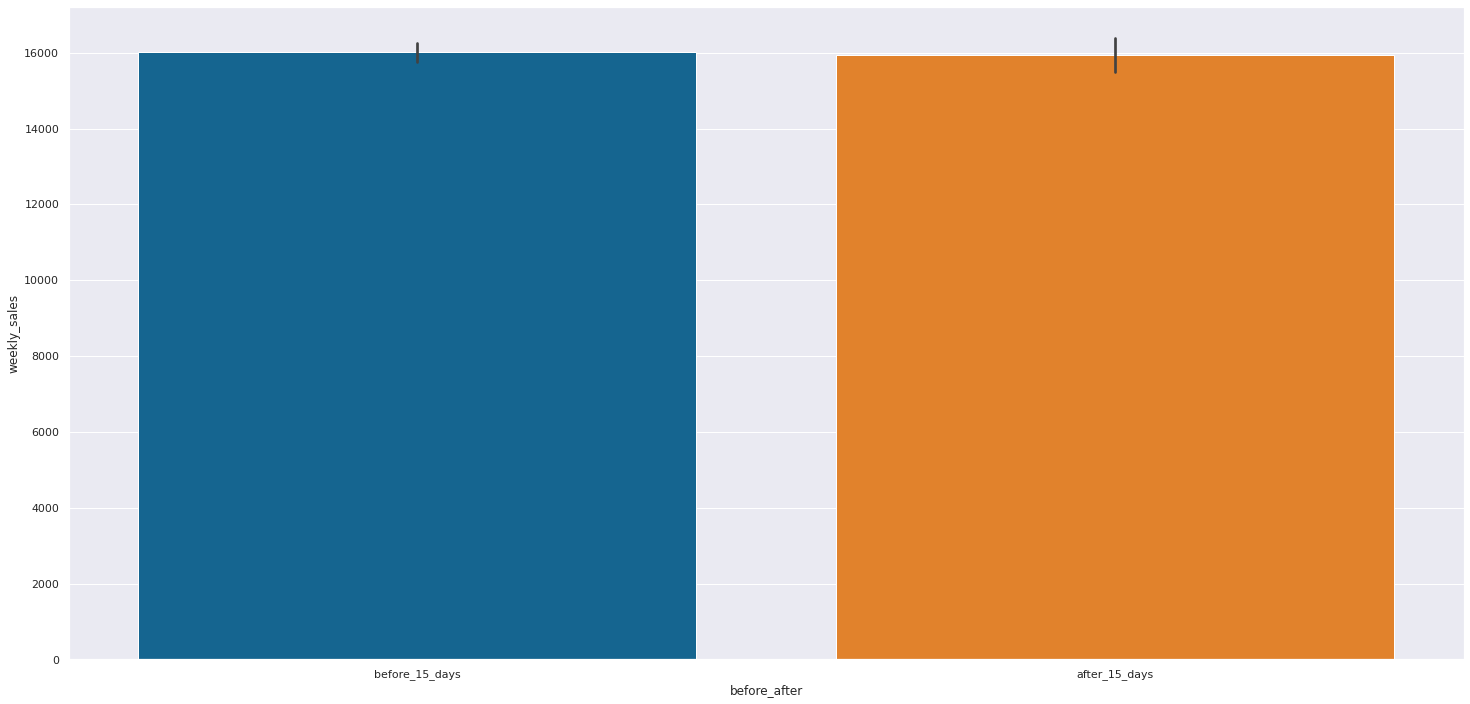

In [62]:
# plot to check sales after and before 2 weeks of each month
aux = df4[['day', 'weekly_sales']].groupby('day').mean().reset_index()
aux['before_after'] = aux['day'].apply(lambda x: 'before_15_days' if x <= 15 else
                                                  'after_15_days')

sns.barplot(data = aux, x= 'before_after', y= 'weekly_sales');

#### **H9.** Places with lower temperatures sell more
**FALSE** Temperature seems to have no relationship with weekly sales

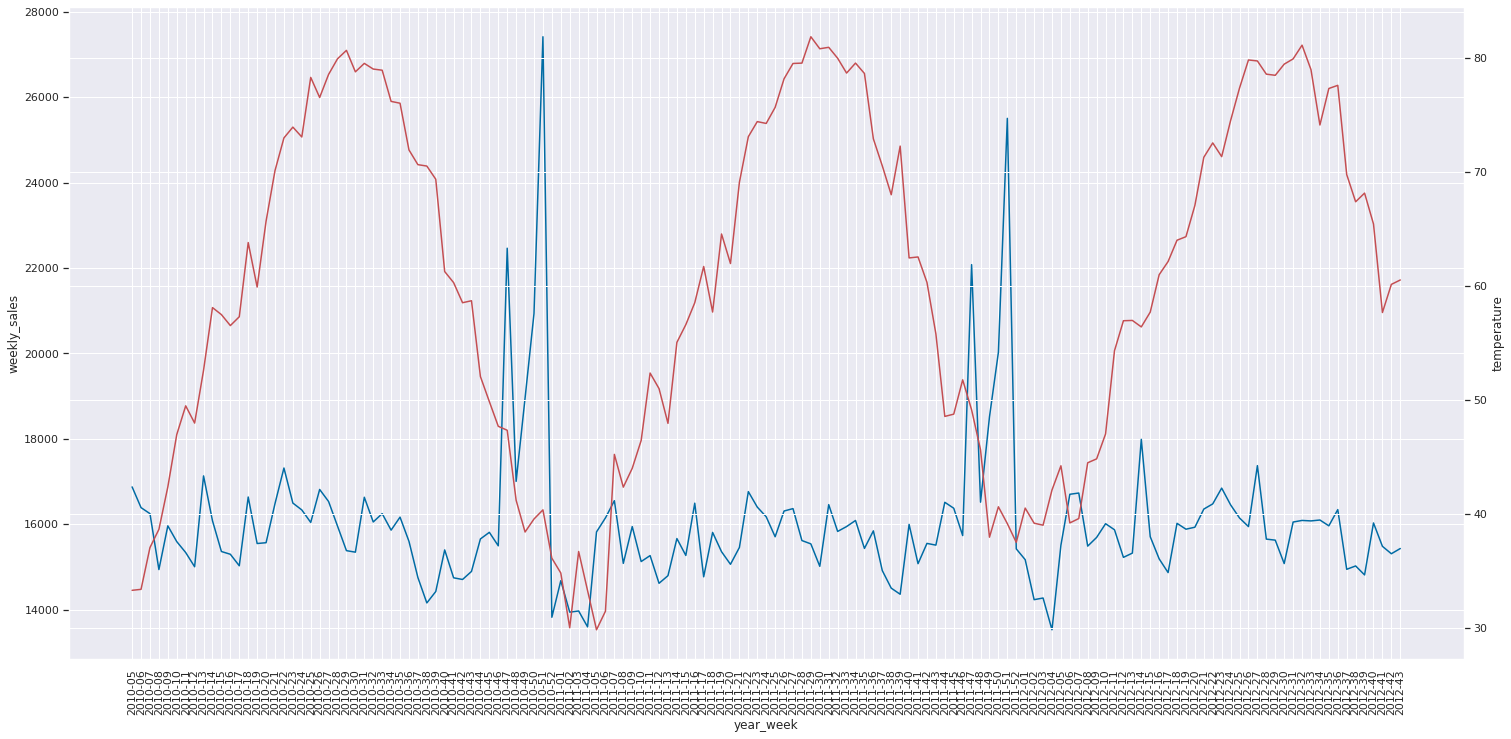

In [63]:
# relationship between temperature and sales over the years
aux = df4[['temperature', 'weekly_sales', 'year_week']].groupby('year_week').mean().reset_index()

sns.lineplot(data = aux, x = 'year_week', y = 'weekly_sales')
plt.xticks(rotation = 90);
ax2 = plt.twinx()
sns.lineplot(data=aux,x = 'year_week', y = 'temperature', color="r", ax=ax2);

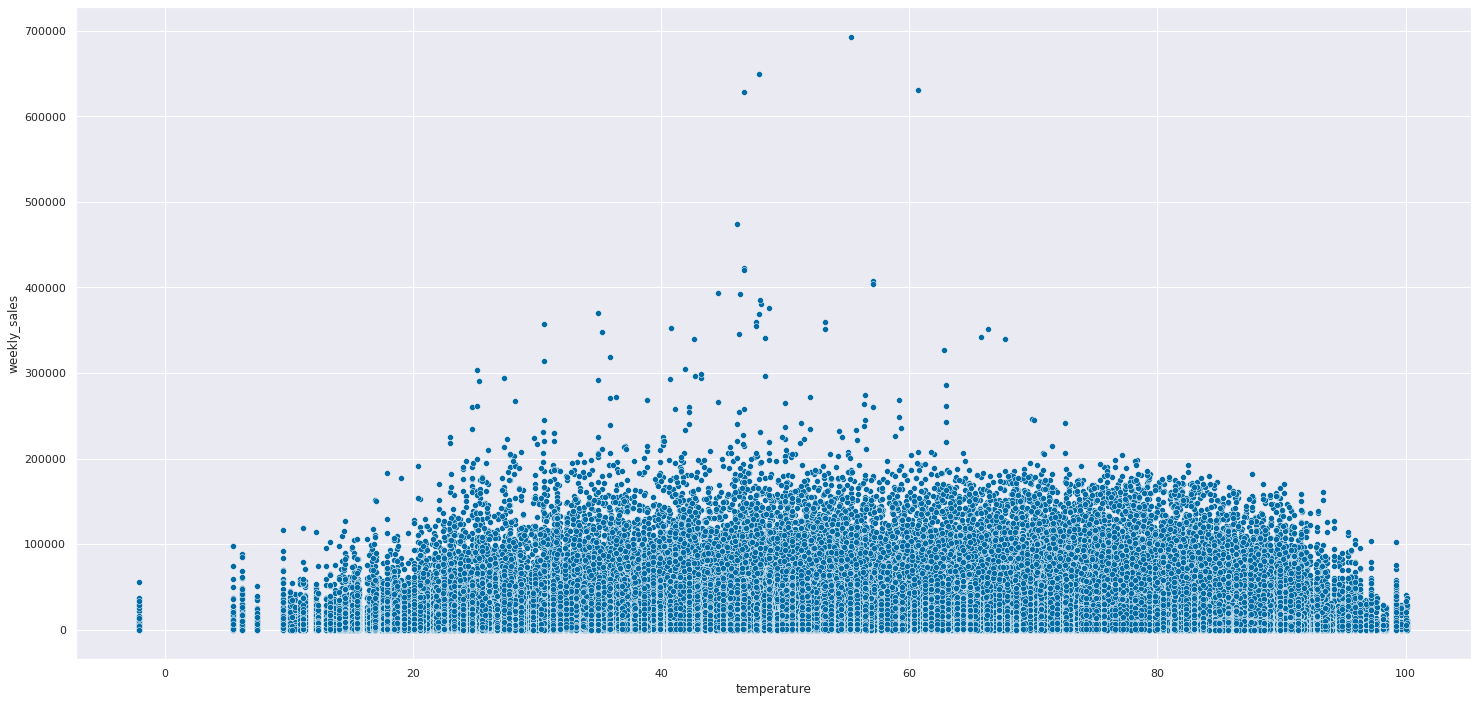

In [64]:
# temperature x weekly sales
sns.scatterplot(x = df4.temperature, y = df4.weekly_sales);

- There seems to be no relatiobship between the temperature in the region and weekly sales of the stores. 
- At low and very high temperatures the sales seems to dip a bit but in general there doesn't exist a clear relationship

#### **H10.** Locations with lower gas prices sell more.
**FALSE** There are no clear reletionship!

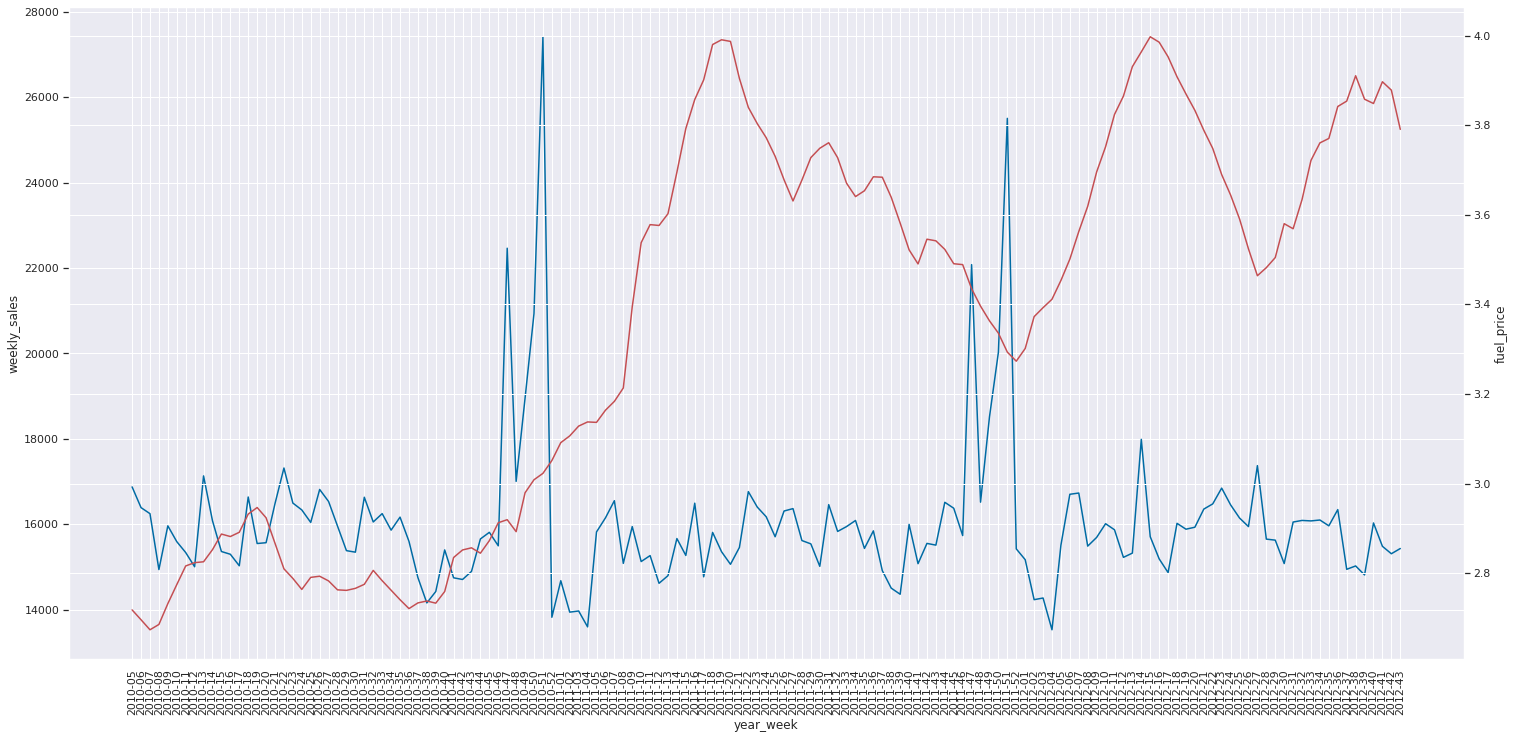

In [65]:
# relationship between temperature and sales over the years
aux = df4[['fuel_price', 'weekly_sales', 'year_week']].groupby('year_week').mean().reset_index()

sns.lineplot(data = aux, x = 'year_week', y = 'weekly_sales')
plt.xticks(rotation = 90);
ax2 = plt.twinx()
sns.lineplot(data=aux,x = 'year_week', y = 'fuel_price', color="r", ax=ax2);

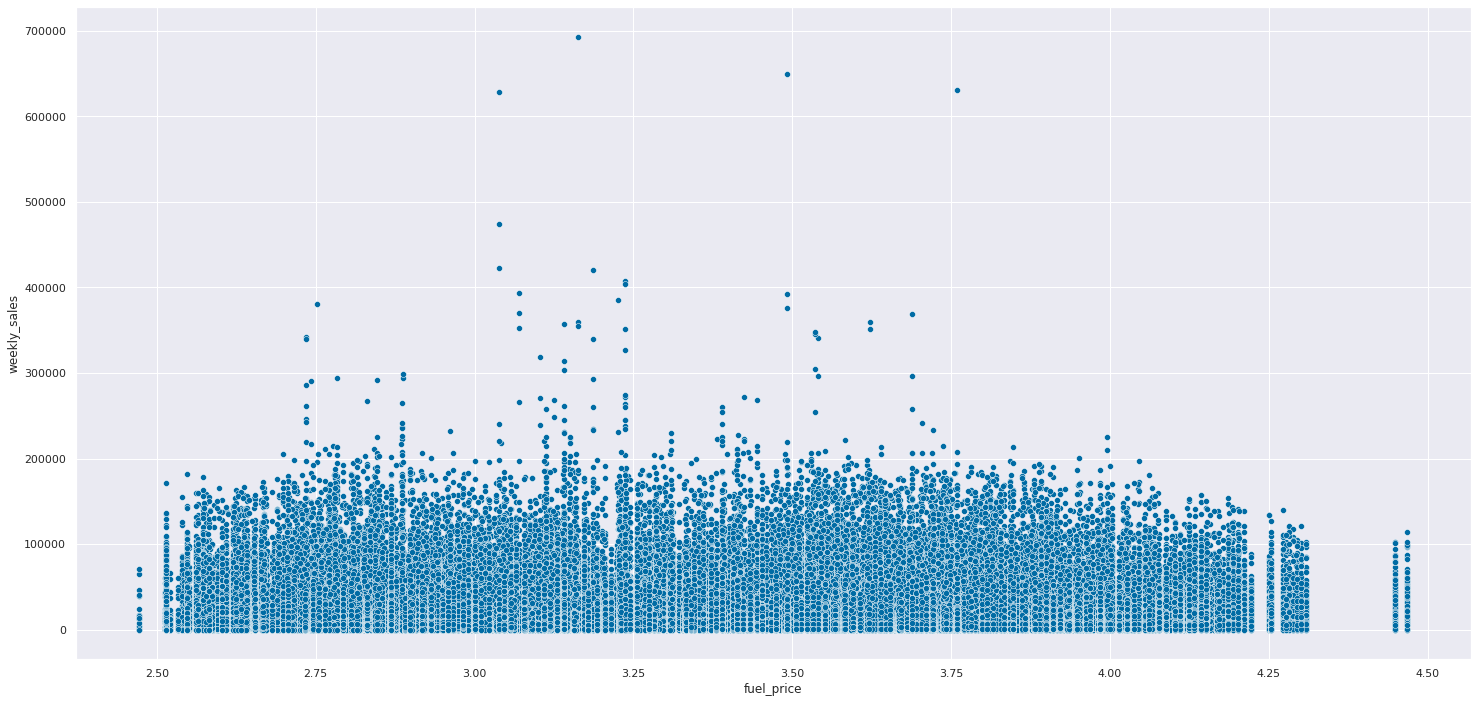

In [66]:
# temperature x weekly sales
sns.scatterplot(x = df4.fuel_price, y = df4.weekly_sales);

- Between fuel price and the sales there doesn't seem to exist any clear relationship

#### **H11.** Places with higher unemployment rate sell less
**FALSE** There are no clear reletionship!

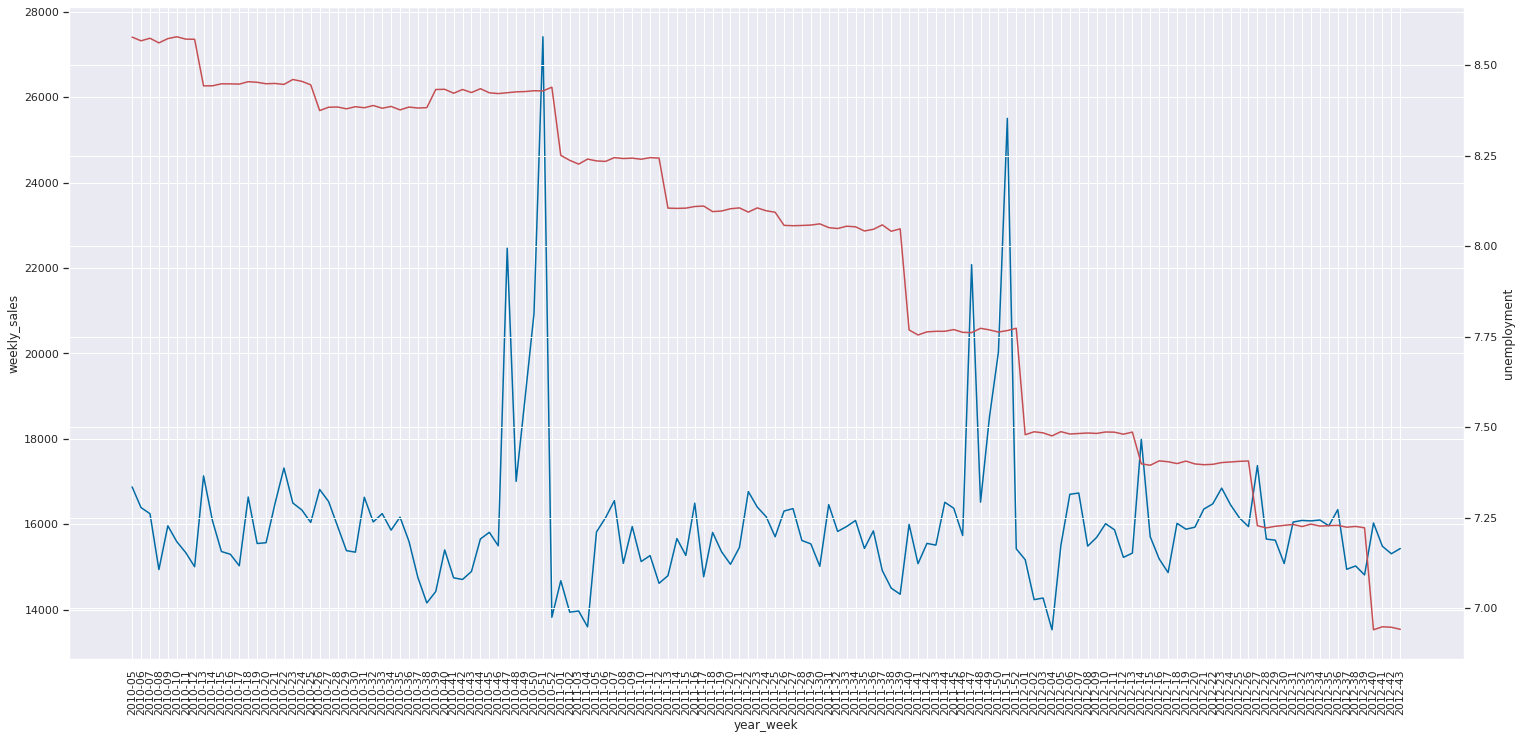

In [67]:
# relationship between Unemployment rate and sales over the years
aux = df4[['unemployment', 'weekly_sales', 'year_week']].groupby('year_week').mean().reset_index()

sns.lineplot(data = aux, x = 'year_week', y = 'weekly_sales')
plt.xticks(rotation = 90);
ax2 = plt.twinx()
sns.lineplot(data=aux,x = 'year_week', y = 'unemployment', color="r", ax=ax2);

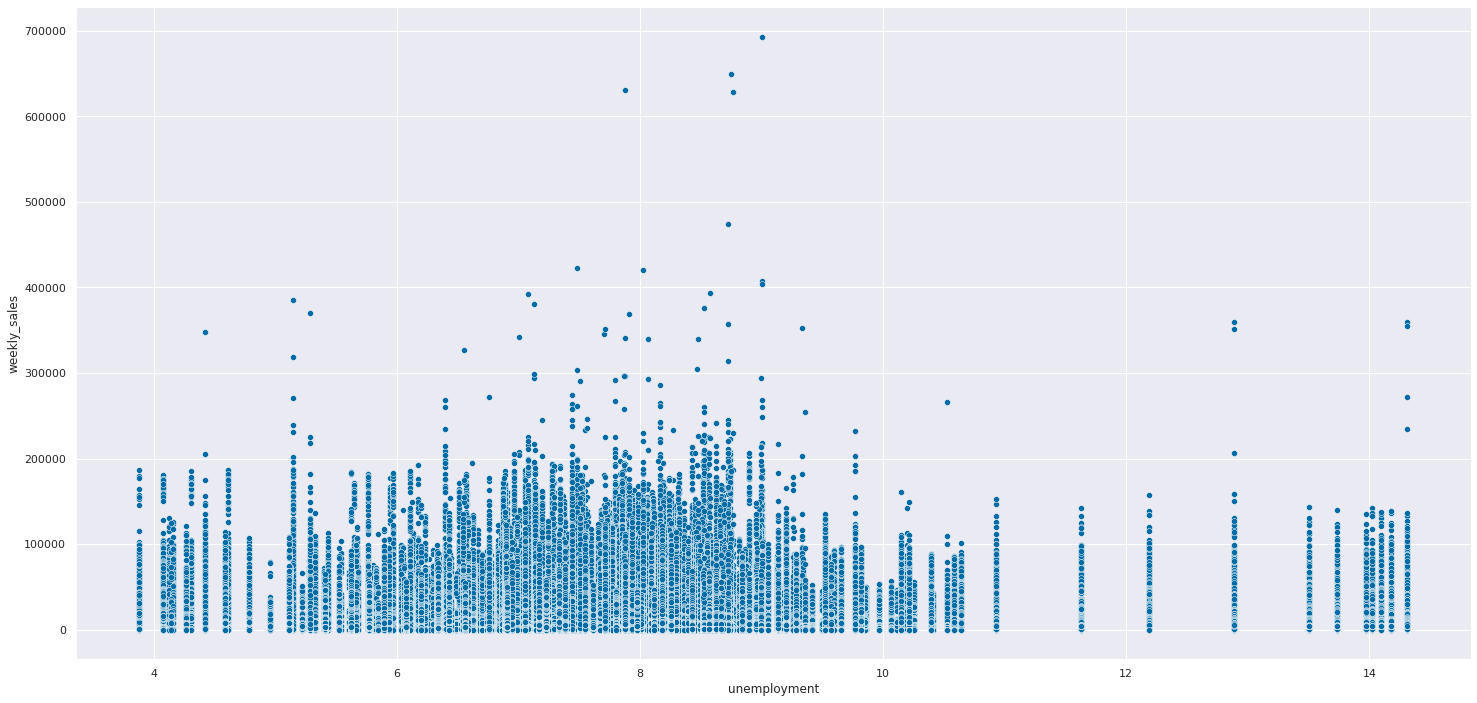

In [68]:
# Unemployment rate x weekly sales
sns.scatterplot(x = df4.unemployment, y = df4.weekly_sales);

#### **H12.** Places with a high consumer confidence index sell more
**FALSE** There are no clear relationship

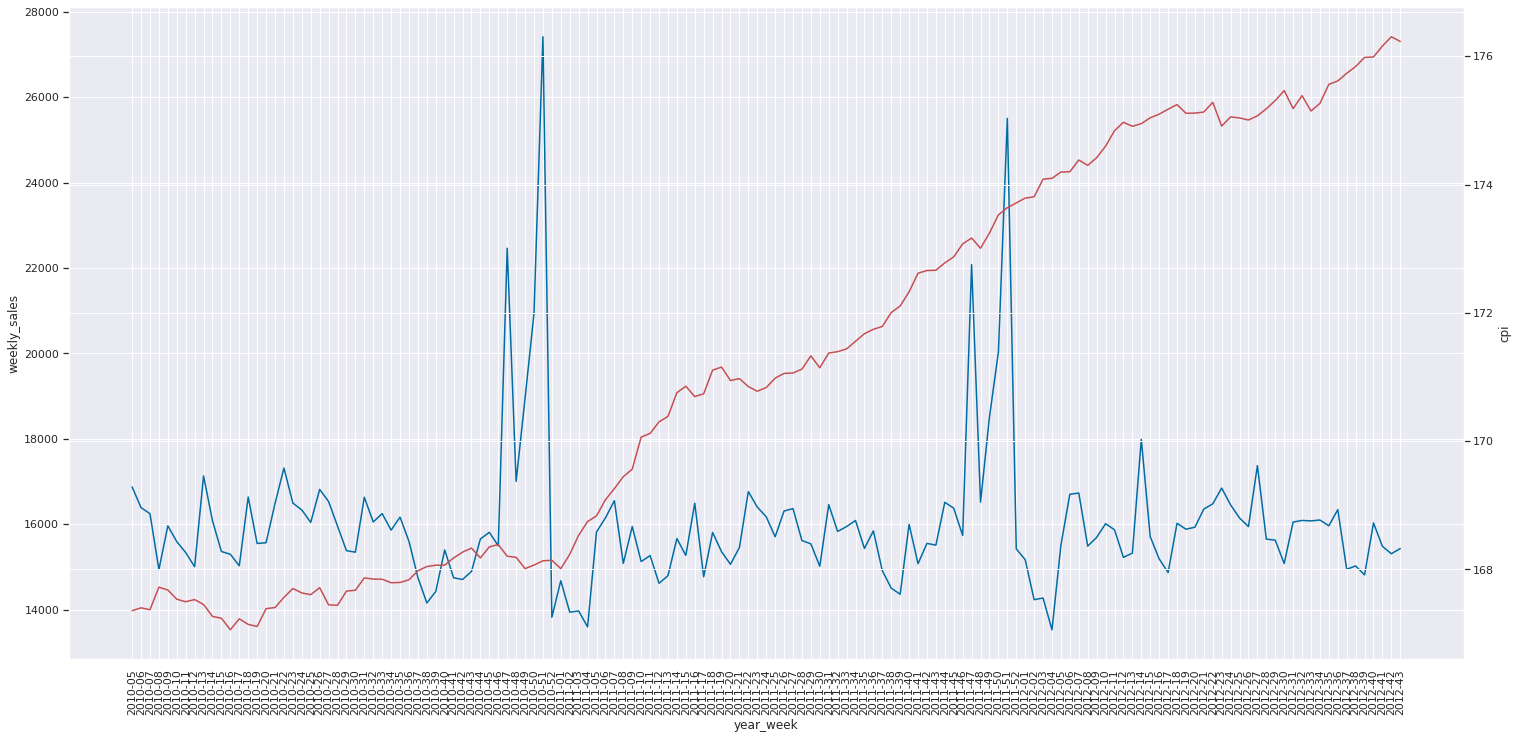

In [69]:
# relationship between CPI and sales over the years
aux = df4[['cpi', 'weekly_sales', 'year_week']].groupby('year_week').mean().reset_index()

sns.lineplot(data = aux, x = 'year_week', y = 'weekly_sales')
plt.xticks(rotation = 90);
ax2 = plt.twinx()
sns.lineplot(data=aux,x = 'year_week', y = 'cpi', color="r", ax=ax2);

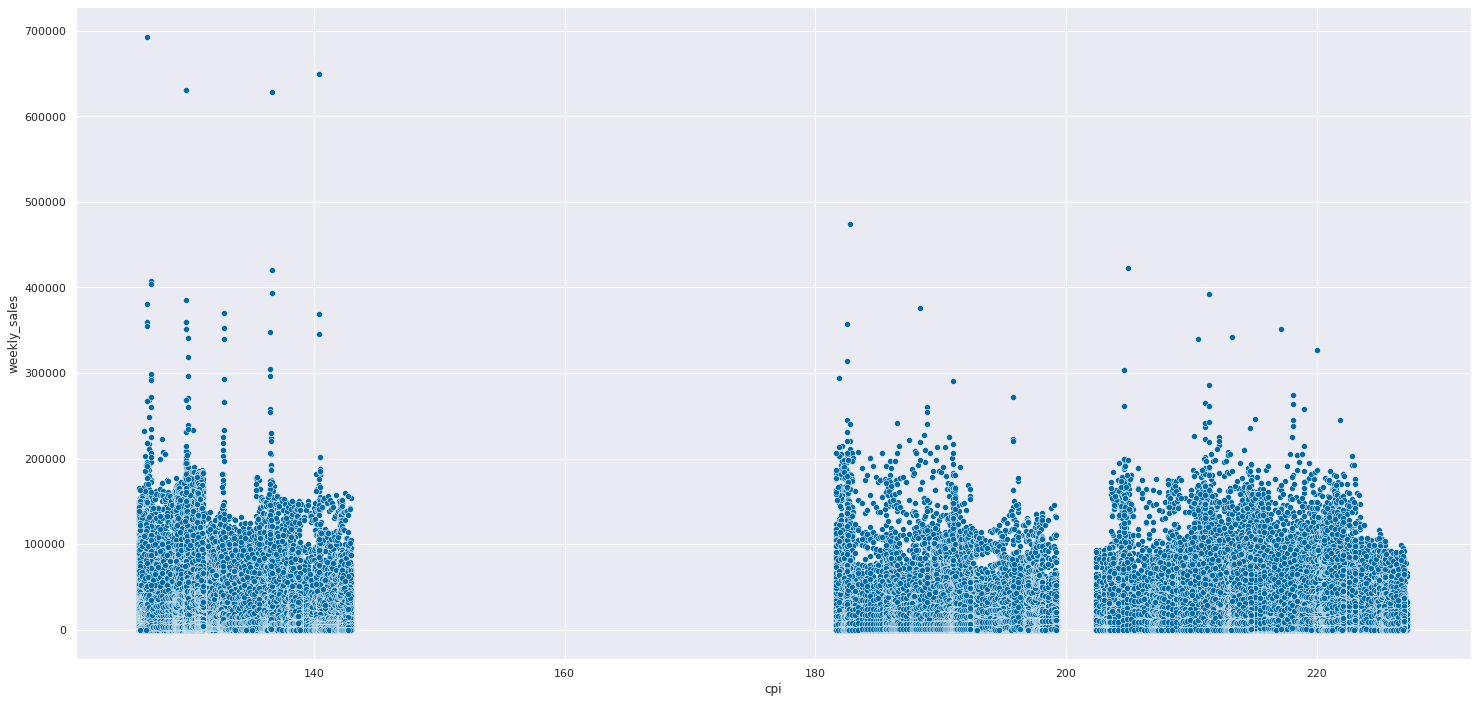

In [70]:
# CPI x weekly sales
sns.scatterplot(x = df4.cpi, y = df4.weekly_sales);

#### 8.2.13 Hypothesis summarize

In [71]:
# Hypothesis Summary to select feature relevance to the model
summary = pd.DataFrame({'Hypothesis':['Larger stores should sell more.',
                                      'Type A stores should sell more.',
                                      'Stores with more departments should sell more.',
                                      'Stores with more aggressive promotions (bigger discounts) should sell more. (markdows)',
                                      'Stores during the Christmas holiday should sell more.',
                                      'Stores should sell more over the years.',
                                      'Stores should sell more in the second half of the year.',
                                      'Stores should sell more after the 2nd week each month.',
                                      'Places with lower temperatures sell more',
                                      'Locations with lower gas prices sell more.',
                                      'Places with higher unemployment rate sell less,',
                                      'Places with a high consumer confidence index sell more.',
                                     ],
                        'True / False':['True', 'True', 'True', 'False', 'True', 'False', 'True', 'False', 'False',
                                        'False','False', 'False'],
                        'Relevance':['High', 'Medium', 'Low', 'Medium', 'Low', 'Low', 'High', 'Low', 'Low', 
                                     'Low', 'Low', 'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

Hypothesis True / False Relevance
1                     Larger stores should sell more.         True      High
2                     Type A stores should sell more.         True    Medium
3      Stores with more departments should sell more.         True       Low
4   Stores with more aggressive promotions (bigger...        False    Medium
5   Stores during the Christmas holiday should sel...         True       Low
6             Stores should sell more over the years.        False       Low
7   Stores should sell more in the second half of ...         True      High
8   Stores should sell more after the 2nd week eac...        False       Low
9            Places with lower temperatures sell more        False       Low
10         Locations with lower gas prices sell more.        False       Low
11    Places with higher unemployment rate sell less,        False       Low
12  Places with a high consumer confidence index s...        False       Low

### 8.3 Multivariate Analysis

- Checking the relationship between the different columns numerically to see how they correlate with the weekly sales in order to confirm the inferences we have evaluated in the above EDA.

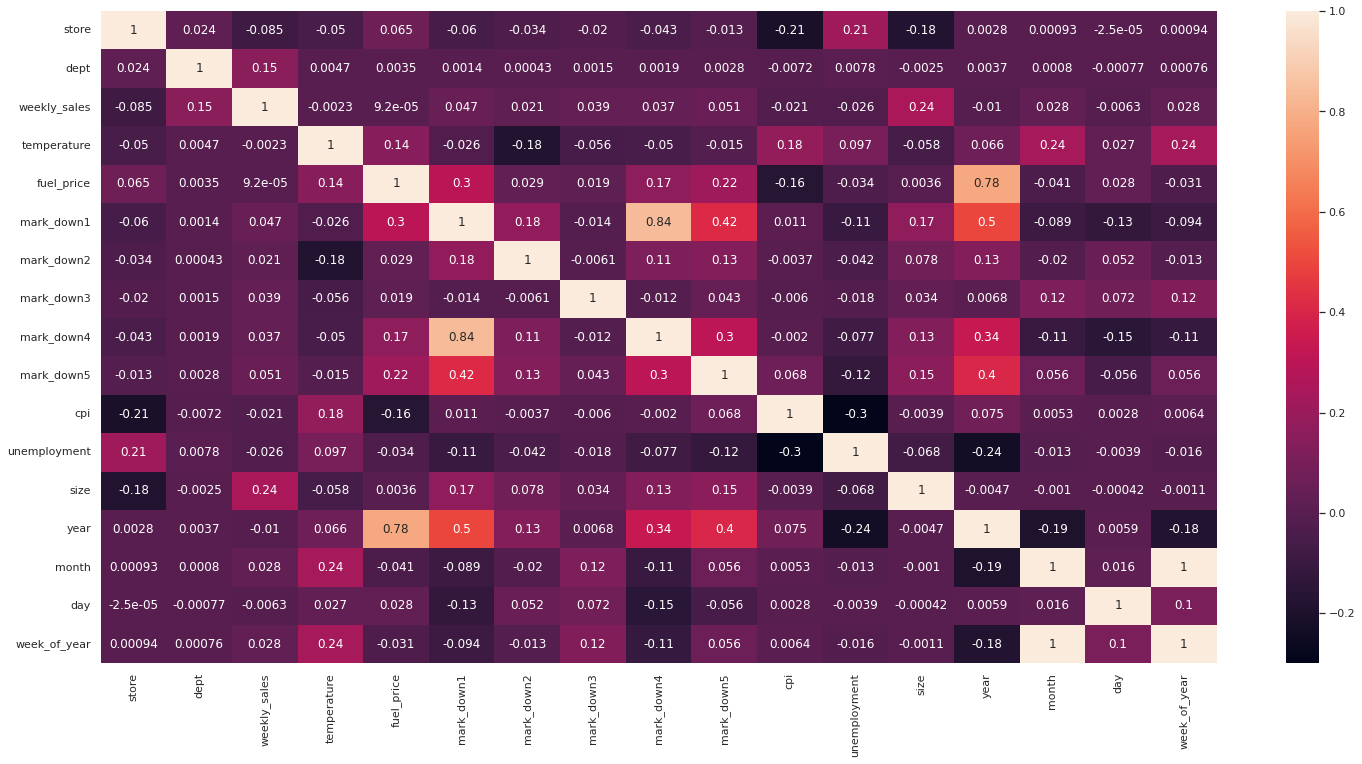

In [72]:
# correlation among all variables
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

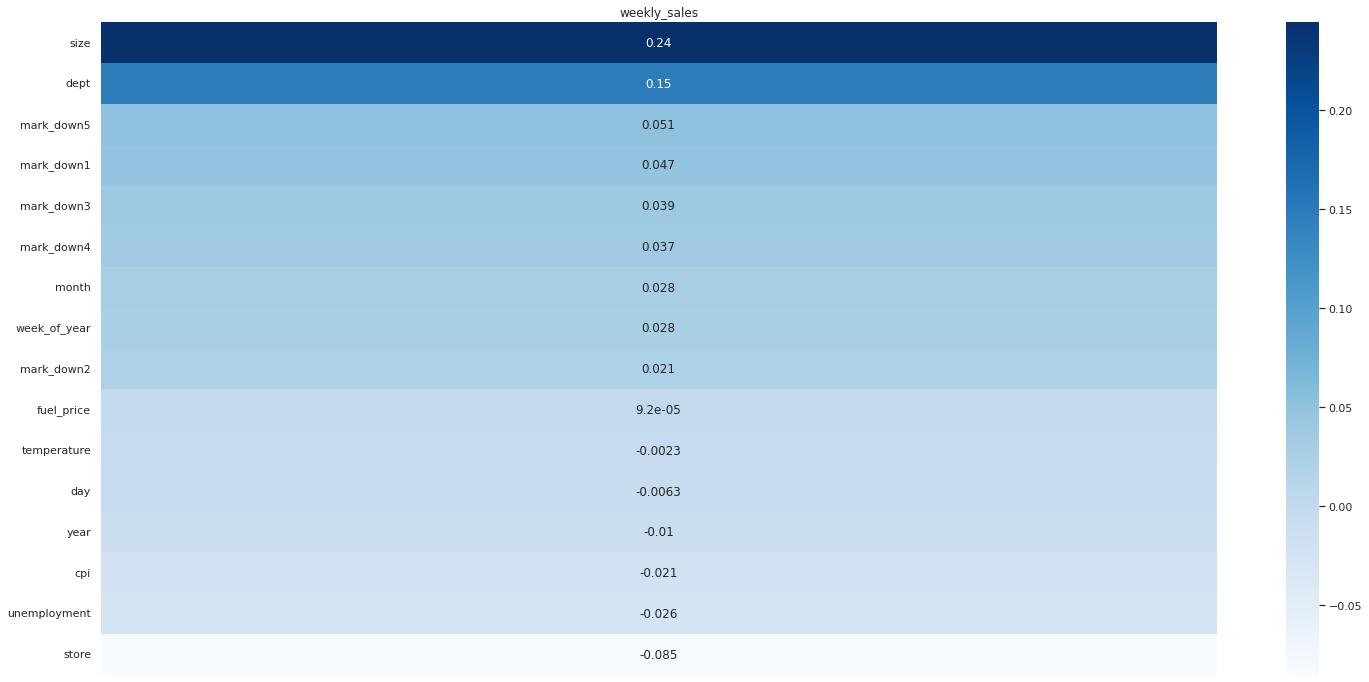

In [73]:
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Blues').set_title(col);
    
    return plot

plot_corr('weekly_sales');

## 9 DATA PREPARATION
<a id="section-nine"></a>

In [17]:
# copy of dataset
df5 = df4.copy()

The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

- Standard Scaler: applied on variables with a distribution shape similar to a normal distribution;
- Min-Max Scaler: applied on variables with low outliers influence;
- Robust Scaler: applied on variables with high outliers influence.

### 9.1 Split dataframe into training and validation

- Here I'm going to split the dataframe into train and validation (Proportion 85/15)
- I'm doing that before data preparation to avoid data leakeage.
- Data prep will be applied into train dataset (fit_transform), and after that it will be applied in the validation dataset (only transform).
- The same will be done in the test data at the end of modelling.
- Using temporal variable is a more reliable way of splitting datasets whenever the dataset includes the date variable, and we want to predict something in the future

In [23]:
# checking the max date in the dataframe
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] 

Timestamp('2012-10-26 00:00:00')

In [24]:
# checking 22 weeks before
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( weeks = 22 )

Timestamp('2012-05-25 00:00:00')

In [18]:
# Spliting dataframe into train and validation. 
# Validation will have the last 22 weeks of sales which represents 16% of the data
# starting at 12-05-25 until the last day of sales

df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( weeks = 22 )

# Train dataset
X_train = df5[df5['date'] < '2012-05-25']
y_train = X_train['weekly_sales']

# Validation dataset
X_validation = df5[df5['date'] >= '2012-05-25']
y_validation = X_validation['weekly_sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nValidation Min Date: {}'.format( X_validation['date'].min() ) )
print( 'Validation Max Date: {}'.format( X_validation['date'].max() ) )

Training Min Date: 2010-02-05 00:00:00
Training Max Date: 2012-05-18 00:00:00

Validation Min Date: 2012-05-25 00:00:00
Validation Max Date: 2012-10-26 00:00:00


In [19]:
# check the proportion of validation data datapoints
X_validation.shape[0]/df5.shape[0] * 100

16.132148423093852

### 9.2 Checking features outliers presence

In [27]:
num_attributes = X_train.select_dtypes( exclude = 'object')

In the plot below:

- 'temperature', 'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5', 'cpi', 'unemployment', 'size', 'year', 'month', 'day', 'week_of_year'

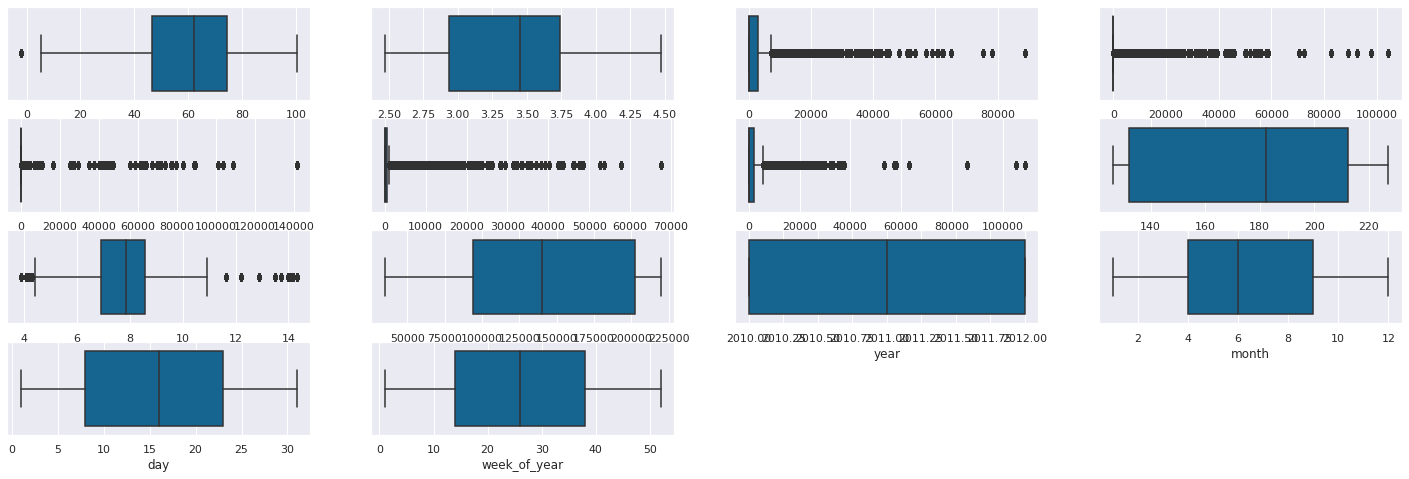

In [28]:
# plot boxplots features in order to check outliers presence
plt.subplot(6, 4, 9)
sns.boxplot(df5['temperature'])

plt.subplot(6, 4, 10)
sns.boxplot(df5['fuel_price'])

plt.subplot(6, 4, 11)
sns.boxplot(df5['mark_down1'])

plt.subplot(6, 4, 12)
sns.boxplot(df5['mark_down2'])

plt.subplot(6, 4, 13)
sns.boxplot(df5['mark_down3'])

plt.subplot(6, 4, 14)
sns.boxplot(df5['mark_down4'])

plt.subplot(6, 4, 15)
sns.boxplot(df5['mark_down5']);

plt.subplot(6, 4, 16)
sns.boxplot(df5['cpi']);

plt.subplot(6, 4, 17)
sns.boxplot(df5['unemployment']);

plt.subplot(6, 4, 18)
sns.boxplot(df5['size']);

plt.subplot(6, 4, 19)
sns.boxplot(df5['year']);

plt.subplot(6, 4, 20)
sns.boxplot(df5['month']);

plt.subplot(6, 4, 21)
sns.boxplot(df5['day']);

plt.subplot(6, 4, 22)
sns.boxplot(df5['week_of_year']);

fig.tight_layout()

### 9.3 Feature Normalization

**None of the attributes follow a normal distribution**

### 9.4 Feature Rescaling

In [19]:
rs = RobustScaler()  #selection of the rescaling method is due to outliers
                     #same formula as minmaxScaler, but uses interquatis itervals as range, being robust to outliers

mms = MinMaxScaler() #super sensitive to outliers

#features for Robust Scalers

#temperature
X_train['temperature'] = rs.fit_transform( X_train[['temperature']].values ) 
pickle.dump(rs, open(home_path+'/parameters/temperature_scaler.pkl', 'wb'))

# mark_down1
X_train['mark_down1'] = rs.fit_transform( X_train[['mark_down1']].values ) 
pickle.dump(rs, open(home_path+'/parameters/mark_down1_scaler.pkl', 'wb'))

# mark_down2
X_train['mark_down2'] = rs.fit_transform( X_train[['mark_down2']].values ) 
pickle.dump(rs, open(home_path+'/parameters/mark_down2_scaler.pkl', 'wb'))

# mark_down3
X_train['mark_down3'] = rs.fit_transform( X_train[['mark_down3']].values ) 
pickle.dump(rs, open(home_path+'/parameters/mark_down3_scaler.pkl', 'wb'))

# mark_down4
X_train['mark_down4'] = rs.fit_transform( X_train[['mark_down4']].values ) 
pickle.dump(rs, open(home_path+'/parameters/mark_down4_scaler.pkl', 'wb'))

# mark_down5
X_train['mark_down5'] = rs.fit_transform( X_train[['mark_down5']].values ) 
pickle.dump(rs, open(home_path+'/parameters/mark_down5_scaler.pkl', 'wb'))

# unemployment
X_train['unemployment'] = rs.fit_transform( X_train[['unemployment']].values ) 
pickle.dump(rs, open(home_path+'/parameters/unemployment_scaler.pkl', 'wb'))

#Features for MinMaxScaler

# fuel_price
X_train['fuel_price'] = mms.fit_transform( X_train[['fuel_price']].values )
pickle.dump(mms, open(home_path + '/parameters/fuel_price_scaler.pkl', 'wb'))

# cpi
X_train['cpi'] = mms.fit_transform( X_train[['cpi']].values )
pickle.dump(mms, open(home_path + '/parameters/cpi_scaler.pkl', 'wb'))

# size
X_train['size'] = mms.fit_transform( X_train[['size']].values )
pickle.dump(mms, open(home_path + '/parameters/size_scaler.pkl', 'wb'))

# year
X_train['year'] = mms.fit_transform( X_train[['year']].values )
pickle.dump(mms, open(home_path + '/parameters/year_scaler.pkl', 'wb'))

### 9.5 Feature Transformation

#### Encoding

In [20]:
# is_holiday
X_train['is_holiday'] = X_train['is_holiday'].apply(lambda x: 1 if x == True else 0)

# type - Label Encoder
le = LabelEncoder()
X_train['type'] = le.fit_transform( X_train['type'] )
pickle.dump(le, open(home_path + '/parameters/type_scaler.pkl', 'wb'))

#### Response (Target) Variable Transformation

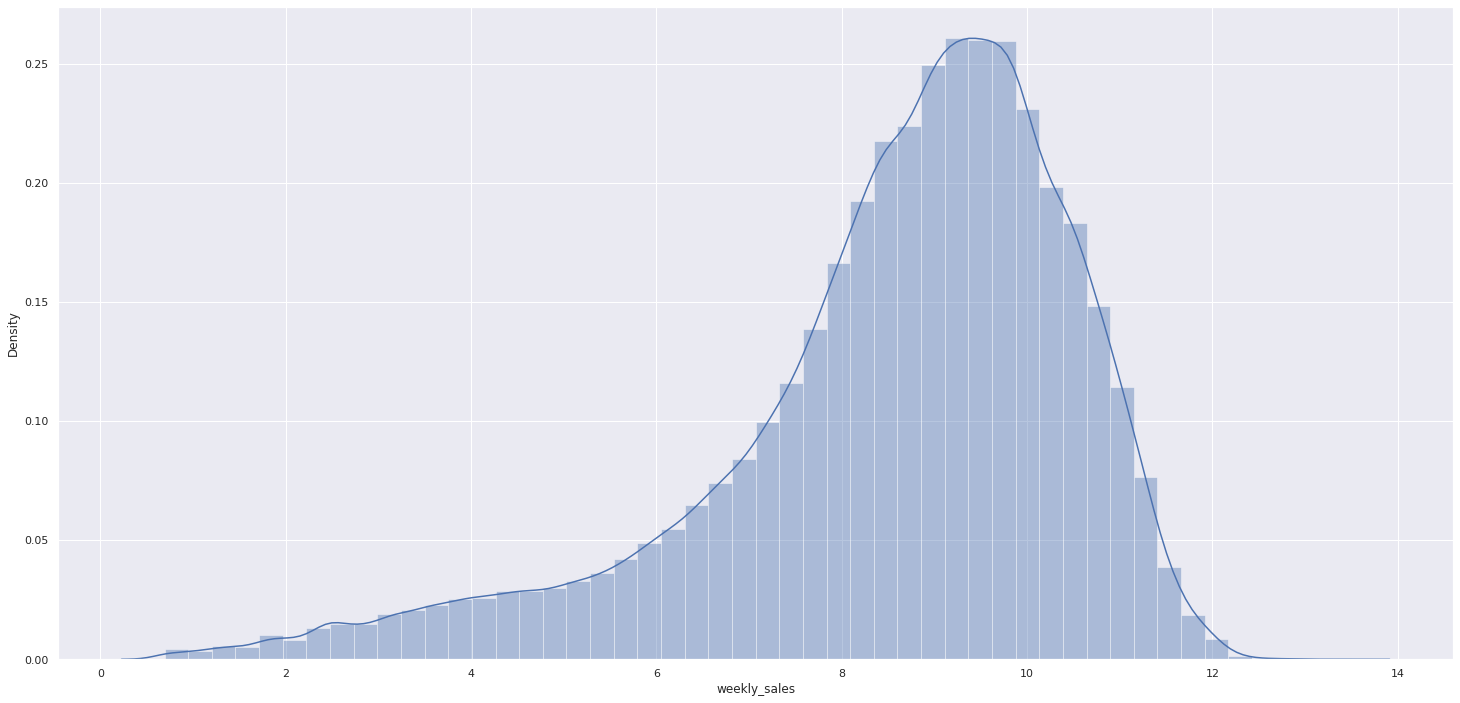

In [21]:
X_train['weekly_sales'] = np.log1p( X_train['weekly_sales'] )
sns.distplot(X_train['weekly_sales']);

- The log transformation is, arguably, the most popular among the different types of transformations used to transform skewed data to approximately conform to normality

#### Nature Transformation

In [22]:
# month
X_train['month_sin'] = X_train['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
X_train['month_cos'] = X_train['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
X_train['day_sin'] = X_train['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
X_train['day_cos'] = X_train['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
X_train['week_of_year_sin'] = X_train['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
X_train['week_of_year_cos'] = X_train['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

- for features that have cyclic behavior: it repeats over time

In [34]:
#check dataframe after rescaling
X_train.head()

store  dept       date  weekly_sales  is_holiday  temperature  fuel_price  mark_down1  mark_down2  mark_down3  mark_down4  mark_down5       cpi  unemployment  type      size  year  month  day  week_of_year year_week quarter  month_sin     month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos
0      1     1 2010-02-05     10.123647           0    -0.592989    0.054466         0.0         0.0         0.0         0.0         0.0  0.855196      0.104153     0  0.630267   0.0      2    5             5   2010-05  2010Q1   0.866025  5.000000e-01  0.866025  0.500000          0.568065          0.822984
1      1     1 2010-02-12     10.737277           1    -0.733210    0.041394         0.0         0.0         0.0         0.0         0.0  0.856663      0.104153     0  0.630267   0.0      2   12             6   2010-06  2010Q1   0.866025  5.000000e-01  0.587785 -0.809017          0.663123          0.748511
2      1     1 2010-02-19     10.635773           0    -0.680812    0.022876         0.0         0.0         0.0         0.0         0.0  0.857135      0.104153     0  0.630267   0.0      2   19             7   2010-07  2010Q1   0.866025  5.000000e-01 -0.743145 -0.669131          0.748511          0.663123
3      1     1 2010-02-26      9.873262           0    -0.433579    0.048475         0.0         0.0         0.0         0.0         0.0  0.857442      0.104153     0  0.630267   0.0      2   26             8   2010-08  2010Q1   0.866025  5.000000e-01 -0.743145  0.669131          0.822984          0.568065
4      1     1 2010-03-05      9.990990           0    -0.438376    0.083333         0.0         0.0         0.0         0.0         0.0  0.857748      0.104153     0  0.630267   0.0      3    5             9   2010-09  2010Q1   1.000000  6.123234e-17  0.866025  0.500000          0.885456          0.464723

### 9.6 Apply Transformations in the Validation dataset

In [23]:
# loading scalers

#Robust Scaler 
temperature_scaler  = pickle.load(open(home_path + 'parameters/temperature_scaler.pkl', 'rb'))
mark_down1_scaler   = pickle.load(open(home_path + 'parameters/mark_down1_scaler.pkl', 'rb'))
mark_down2_scaler   = pickle.load(open(home_path + 'parameters/mark_down2_scaler.pkl', 'rb'))
mark_down3_scaler   = pickle.load(open(home_path + 'parameters/mark_down3_scaler.pkl', 'rb'))
mark_down4_scaler   = pickle.load(open(home_path + 'parameters/mark_down4_scaler.pkl', 'rb'))
mark_down5_scaler   = pickle.load(open(home_path + 'parameters/mark_down5_scaler.pkl', 'rb'))
unemployment_scaler = pickle.load(open(home_path + 'parameters/unemployment_scaler.pkl', 'rb'))

#MinMax Scaler 
fuel_price_scaler   = pickle.load(open(home_path + 'parameters/fuel_price_scaler.pkl', 'rb'))
cpi_scaler          = pickle.load(open(home_path + 'parameters/cpi_scaler.pkl', 'rb'))
size_scaler         = pickle.load(open(home_path + 'parameters/size_scaler.pkl', 'rb'))
year_scaler         = pickle.load(open(home_path + 'parameters/year_scaler.pkl', 'rb'))

#Label enconder
type_scaler         = pickle.load(open(home_path + 'parameters/type_scaler.pkl', 'rb'))

In [24]:
# Applying all transformations on validation dataset
#Validation dataset features transform - Robust Scaler
X_validation['temperature'] = temperature_scaler.transform( X_validation[['temperature']].values ) 
X_validation['mark_down1']  = mark_down1_scaler.transform( X_validation[['mark_down1']].values ) 
X_validation['mark_down2']  = mark_down2_scaler.transform( X_validation[['mark_down2']].values ) 
X_validation['mark_down3']  = mark_down3_scaler.transform( X_validation[['mark_down3']].values ) 
X_validation['mark_down4']  = mark_down4_scaler.transform( X_validation[['mark_down4']].values ) 
X_validation['mark_down5']  = mark_down5_scaler.transform( X_validation[['mark_down5']].values ) 
X_validation['unemployment']= unemployment_scaler.transform( X_validation[['unemployment']].values ) 

##Validation dataset features transform - MinMaxScaler
X_validation['fuel_price'] = fuel_price_scaler.transform( X_validation[['fuel_price']].values )
X_validation['cpi']        = cpi_scaler.transform( X_validation[['cpi']].values )
X_validation['size']       = size_scaler.transform( X_validation[['size']].values )
X_validation['year']       = year_scaler.transform( X_validation[['year']].values )

##Validation dataset features transform - Label Enconder
X_validation['type'] = type_scaler.transform( X_validation['type'] )

# is_holiday
X_validation['is_holiday'] = X_validation['is_holiday'].apply(lambda x: 1 if x == True else 0)

# target variable
X_validation['weekly_sales'] = np.log1p( X_validation['weekly_sales'] )

##Validation dataset features transform - Natural Transformations
# month
X_validation['month_sin'] = X_validation['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
X_validation['month_cos'] = X_validation['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
X_validation['day_sin'] = X_validation['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
X_validation['day_cos'] = X_validation['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
X_validation['week_of_year_sin'] = X_validation['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
X_validation['week_of_year_cos'] = X_validation['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [25]:
# new y_train with weekly sales rescaled
y_validation = X_validation['weekly_sales']

y_train = X_train['weekly_sales'] 

## 10 FEATURE SELECTION
<a id="section-ten"></a>

- Selecting the most relevant features that describes our dataset (phenomenon). removing collinear features, its explain the same part of the phenomenon.

- Always prefer the simplest model! occla's razors idea

In [26]:
df6 = X_train.copy()

In [27]:
# deleting features after feature engineering derivation and transformations. Deleting original variables.
cols_drop = ['week_of_year', 'day', 'month', 'year_week', 'quarter']
df6 = df6.drop(cols_drop, axis = 1)

In [40]:
df6.dtypes

store                        int64
dept                         int64
date                datetime64[ns]
weekly_sales               float64
is_holiday                   int64
temperature                float64
fuel_price                 float64
mark_down1                 float64
mark_down2                 float64
mark_down3                 float64
mark_down4                 float64
mark_down5                 float64
cpi                        float64
unemployment               float64
type                         int64
size                       float64
year                       float64
month_sin                  float64
month_cos                  float64
day_sin                    float64
day_cos                    float64
week_of_year_sin           float64
week_of_year_cos           float64
dtype: object

### 10.1 Boruta as a Feature Selector

In [93]:
# # creating training and test dataset for Boruta, because it can't be a dataframe type
# X_train_n = df6.drop( ['date', 'weekly_sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 10.2 Best Features from Boruta

In [94]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = df6.drop(['date', 'weekly_sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[ :, cols_selected].columns.tolist()

# # Not selected boruta features
# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [95]:
# cols_selected_boruta

In [96]:
# cols_not_selected_boruta

- Due to the computational power required for Boruta, the lines above were commented out so the algorithm doesn't run every time.

### 10.3 Best Features from Random Forest

In [27]:
X_train = df6.drop( ['date', 'weekly_sales'], axis=1 ).copy()
y_train = df6['weekly_sales'].copy()

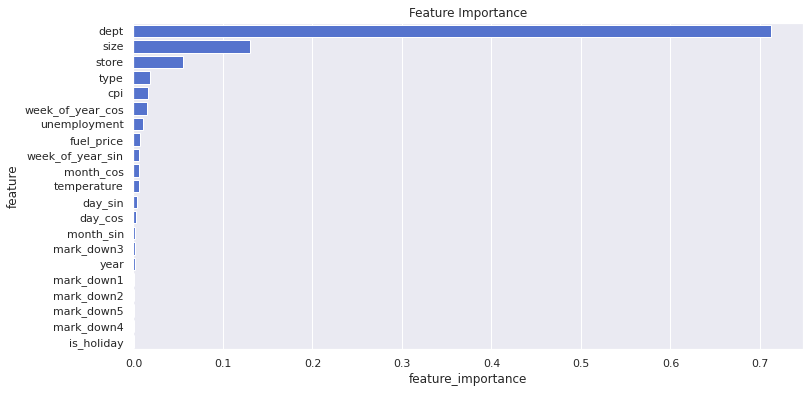

In [176]:
# train random forest classifier
rf = RandomForestRegressor(n_estimators = 200, n_jobs =-1, random_state = 42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

### 10.4 Manual Feature Selection

In [28]:
cols_selected_boruta = ['store',
'dept',
'is_holiday',
'type',
'cpi',
'size',
'month_cos',
'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'weekly_sales']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [99]:
# cols_selected_boruta = ['store',
# 'dept',
# 'is_holiday',
# 'temperature',
# 'fuel_price',
# 'mark_down3',
# 'cpi',
# 'unemployment',
# 'type',
# 'size',
# 'month_cos',
# 'day_sin',
# 'day_cos',
# 'week_of_year_sin',
# 'week_of_year_cos']
# # columns to add
# feat_to_add = ['date', 'weekly_sales']

# # final features

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend( feat_to_add )

In [100]:
pd.DataFrame(data = cols_selected_boruta, columns = ['feature_selected'])

feature_selected
0              store
1               dept
2         is_holiday
3        temperature
4         fuel_price
5         mark_down3
6                cpi
7       unemployment
8               type
9               size
10         month_cos
11           day_sin
12           day_cos
13  week_of_year_sin
14  week_of_year_cos

In [42]:
pd.DataFrame(data = cols_selected_boruta, columns = ['feature_selected'])

feature_selected
0             store
1              dept
2        is_holiday
3              type
4               cpi
5              size
6         month_cos
7  week_of_year_cos

## 11 MACHINE LEARNING ALGORITHM MODELS
<a id="section-eleven"></a>

**Four different algorithms are going to be used to predict the target variable:**

- **Average:** averaging model is the model we use most in everyday life, it will always predict the average. It is useful as it is a comparative basis for implementing other models

- **Linear Regression:** Regression analysis allows you to understand the strength of relationships between variables. Tells you what predictors in a model are statistically significant and which are not. It is less of a black box and is easier to communicate.

- **Random Forest:** it is a tree based model build with multiple ensamble decision trees created with the bagging method. Then, all the classifiers take a weighted vote on their predictions. Since the algorithm goal is not trying to find a linear function to describe the event, it works for problems with more complex behaviour

- **XGBoost:** it is also a tree based model but they are built in a different way. While Random Forests builds each tree independently, XGBoost builds one tree at the time learning with its predecessor. Therefore, this algorithm doesn't combine results at the end of the process by taking majority votes, it combines the results along the way

- **LightGBM:** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

 - Faster training speed and higher efficiency.
 - Lower memory usage.
 - Better accuracy.
 - Support of parallel, distributed, and GPU learning.
 - Capable of handling large-scale data.

- if we have multiple models to choose from, we should choose the least complex model as they generalize learning better.

In [29]:
# Applying selected features by boruta on train and validation datasets
x_train = X_train[ cols_selected_boruta ].copy() #selecting only the columns selected by boruta
x_validation = X_validation[ cols_selected_boruta ].copy()

# Time Series Data Preparation for cross-validation
x_training = df6[ cols_selected_boruta_full ].copy()

### 11.1 Average Model

In [ ]:
# averaging model is the model we use most in everyday life, it will always predict the average.
# It is useful as it is a comparative basis for implementing other models

# analisando o resultado dos erros de cada modelo testado, percebe-se que erros maiores aconteceram nas regressões lineares
## ou seja, o conjunto de dados é complexo, não segue uma linearidade. Modelos apresentaram erros maiores que a média!

In [31]:
aux1 = x_validation.copy()
aux1['weekly_sales'] = y_validation.copy()

# Predictions
aux2 = aux1[['store', 'weekly_sales']].groupby('store').mean().reset_index().rename(columns = {'weekly_sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how= 'left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( aux1 ,'Average Model', np.expm1( y_validation ), np.expm1( yhat_baseline ))
baseline_result

Model Name           MAE         RMSE     WMAE
0  Average Model  12924.054151  23496.32364  2439.03

### 11.2 Linear Regression Model

In [49]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction 
yhat_lr = lr.predict( x_validation )

# Performance
lr_result = ml_error( x_validation,'Linear Regression', np.expm1(y_validation), np.expm1(yhat_lr))
lr_result

Model Name          MAE         RMSE     WMAE
0  Linear Regression  13055.26203  23476.22923  13129.5

#### Linear Regression Model - Cross Validation

In [50]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

Model Name               MAE CV              RMSE CV  \
0  Linear Regression  13160.62 +/- 241.11  24354.51 +/- 1052.9   

              WMAE CV  
0  13341.3 +/- 435.11

### 11.3 Linear Regression Regularized Model - Lasso

In [51]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_validation )

# performance
lrr_result = ml_error( x_validation,'Linear Regression - Lasso', np.expm1( y_validation ), np.expm1( yhat_lrr ) )
lrr_result

Model Name           MAE          RMSE      WMAE
0  Linear Regression - Lasso  13054.810288  23511.683122  13132.65

#### Linear Regression Regularized Model - Lasso

In [52]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized Model - Lasso', lrr, verbose=False )
lrr_result_cv

Model Name               MAE CV  \
0  Linear Regression Regularized Model - Lasso  13163.57 +/- 239.89   

                RMSE CV              WMAE CV  
0  24393.81 +/- 1038.39  13354.87 +/- 441.74

### 11.4 Random Forest Regressor

In [31]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1, random_state=7 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_validation )

# performance
rf_result = ml_error( x_validation,'Random Forest Regressor', np.expm1( y_validation ), np.expm1( yhat_rf ) )
rf_result

Model Name          MAE         RMSE     WMAE
0  Random Forest Regressor  1761.420258  3662.683635  1804.25

#### Random Forest Regressor - Cross Validation

In [32]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

Model Name            MAE CV              RMSE CV  \
0  Random Forest Regressor  2775.0 +/- 558.1  6953.63 +/- 2207.34   

             WMAE CV  
0  2872.34 +/- 594.1

### 11.5 XGBoost Regressor

In [57]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators = 100, random_state=7).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_validation )

# performance
xgb_result = ml_error(x_validation ,'XGBoost Regressor', np.expm1( y_validation ), np.expm1( yhat_xgb ) )
xgb_result

Model Name          MAE         RMSE     WMAE
0  XGBoost Regressor  2952.726842  6074.153196  3007.36

#### XGBoost Regressor - Cross Validation

In [58]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

Model Name              MAE CV              RMSE CV             WMAE CV
0  XGBoost Regressor  3685.23 +/- 304.57  8613.26 +/- 1644.38  3803.76 +/- 414.59

In [148]:
xgb_result_cv

Model Name               MAE CV      MAPE CV              RMSE CV             WMAE CV
0  XGBoost Regressor  15697.52 +/- 216.71  inf +/- nan  27548.58 +/- 969.64  15893.9 +/- 430.09

### 11.6 LightGBM Regressor

In [68]:
# model
model_lgbm = lgbm.LGBMRegressor(n_estimators = 100, n_jobs =-1, random_state=7).fit( x_train, y_train )

# prediction
yhat_lgbm = model_lgbm.predict( x_validation )

# performance
lgbm_result = ml_error(x_validation ,'LightGBM Regressor', np.expm1( y_validation ), np.expm1( yhat_lgbm ) )
lgbm_result

Model Name          MAE        RMSE     WMAE
0  LightGBM Regressor  4399.577198  8826.42911  4453.36

#### LightGBM Regressor - Cross Validation

In [64]:
lgbm_result_cv = cross_validation( x_training, 5, 'LightGBM Regressor', model_lgbm, verbose=False )
lgbm_result_cv

Model Name              MAE CV               RMSE CV             WMAE CV
0  LightGBM Regressor  4884.15 +/- 250.16  10879.84 +/- 1668.93  5072.19 +/- 387.73

### 11.7 Compare Model's Performance

#### 11.7.1 Single Performance - 1 fold

In [99]:
results = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result ] ).set_index('Model Name')
results.sort_values('RMSE')

MAE          RMSE      WMAE
Model Name                                                     
Random Forest Regressor     1761.420258   3662.683635   1804.25
XGBoost Regressor           2952.726842   6074.153196   3007.36
LightGBM Regressor          4399.577198   8826.429110   4453.36
Linear Regression          13055.262030  23476.229230  13129.50
Average Model              12924.054151  23496.323640   2439.03
Linear Regression - Lasso  13054.810288  23511.683122  13132.65

#### 11.7.2 Real Performance - Cross Validation - 5 folds

In [101]:
results_cv = pd.concat([lr_result_cv , lrr_result_cv , rf_result_cv, xgb_result_cv, lgbm_result_cv]).set_index('Model Name')
results_cv

MAE CV               RMSE CV              WMAE CV
Model Name                                                                                                 
Linear Regression                            13160.62 +/- 241.11   24354.51 +/- 1052.9   13341.3 +/- 435.11
Linear Regression Regularized Model - Lasso  13163.57 +/- 239.89  24393.81 +/- 1038.39  13354.87 +/- 441.74
Random Forest Regressor                         2775.0 +/- 558.1   6953.63 +/- 2207.34    2872.34 +/- 594.1
XGBoost Regressor                             3685.23 +/- 304.57   8613.26 +/- 1644.38   3803.76 +/- 414.59
LightGBM Regressor                            4884.15 +/- 250.16  10879.84 +/- 1668.93   5072.19 +/- 387.73

- The choosen model was the one with the best performance with crossvalidation -> **Random Forest Regressor**

- If our use case demands that occasional large mistakes in your predictions need to be avoided then use RMSE, however if you want an error metric that treats all errors equally and returns a more interpretable error value then use MAE.

## 12 HYPERPARAMETERS FINE TUNING
<a id="section-twelve"></a>

### 12.1 Random Search

In [45]:
param = {
    'n_estimators': [300, 400] ,
    'max_features': ['auto'],
    'max_depth': [21,25,31],
    'min_samples_split':[5, 7] ,
    'min_samples_leaf': [1, 2, 5],
        }

MAX_EVAL = 5; #quantas iterações temos

In [46]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    
    # model
    model_rf = RandomForestRegressor(n_estimators = hp['n_estimators'],
                                  max_features = hp['max_features'],
                                  max_depth = hp['max_depth'],
                                  min_samples_split = hp['min_samples_split'],
                                  min_samples_leaf = hp['min_samples_leaf'],
                                  random_state = 7,
                                  n_jobs = -1)
    
    # performance
    result = cross_validation( x_training, 5, 'Random Forest Regressor', model_rf, verbose = True)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 300, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 5}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 300, 'max_features': 'auto', 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 5}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 5}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV              RMSE CV  \
0  Random Forest Regressor  2777.09 +/- 540.99  6978.07 +/- 2148.38   
0  Random Forest Regressor  2820.97 +/- 470.63  7257.43 +/- 1953.07   
0  Random Forest Regressor  2818.97 +/- 471.34  7258.44 +/- 1953.66   
0  Random Forest Regressor  2763.79 +/- 520.16  6985.35 +/- 2097.38   
0  Random Forest Regressor  2820.97 +/- 470.63  7257.43 +/- 1953.07   

              WMAE CV  
0  2885.37 +/- 575.59  
0  2966.29 +/- 506.17  
0  2963.41 +/- 506.63  
0  2877.71 +/- 554.61  
0  2966.29 +/- 506.17

In [44]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    
    # model
    model_rf = RandomForestRegressor(n_estimators = hp['n_estimators'],
                                  max_features = hp['max_features'],
                                  max_depth = hp['max_depth'],
                                  min_samples_split = hp['min_samples_split'],
                                  min_samples_leaf = hp['min_samples_leaf'],
                                  random_state = 7,
                                  n_jobs = -1)
    
    # performance
    result = cross_validation( x_training, 5, 'Random Forest Regressor', model_rf, verbose = True)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 30, 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 20}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 30, 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 30, 'max_features': 'auto', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 50}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name               MAE CV               RMSE CV  \
0  Random Forest Regressor  12621.94 +/- 251.25  24166.19 +/- 1116.56   
0  Random Forest Regressor  11068.53 +/- 304.08  21761.48 +/- 1285.86   
0  Random Forest Regressor  12621.94 +/- 251.25  24166.19 +/- 1116.56   
0  Random Forest Regressor    7696.37 +/- 590.0  15916.38 +/- 2001.41   
0  Random Forest Regressor   10952.16 +/- 351.3  21599.52 +/- 1408.24   

               WMAE CV  
0  12818.18 +/- 444.39  
0  11262.77 +/- 495.94  
0  12818.18 +/- 444.39  
0   7878.84 +/- 672.56  
0  11144.14 +/- 516.17

### 12.2 Final Model

In [30]:
param_tuned = {
    'n_estimators':300,
    'max_features': 'auto',
    'min_samples_split': 5,
    'min_samples_leaf': 1 ,
        }

In [31]:
# model
model_rf_tuned = RandomForestRegressor(n_estimators = param_tuned['n_estimators'],
                                  max_features      = param_tuned['max_features'],
                                  min_samples_split = param_tuned['min_samples_split'],
                                  min_samples_leaf  = param_tuned['min_samples_leaf'],
                                  n_jobs = -1,
                                  random_state = 7).fit(x_train, y_train)

#prediction
yhat_rf_tuned = model_rf_tuned.predict(x_validation)

# performance
rf_tuned_result = ml_error( x_validation,'Random Forest Regressor', np.expm1(y_validation) , np.expm1(yhat_rf_tuned))
rf_tuned_result

Model Name          MAE         RMSE     WMAE
0  Random Forest Regressor  1763.063653  3664.589588  1807.95

## 13 ERROR INTERPRETATION
<a id="section-thirteen"></a>

In [34]:
# selecting validation dataframe to evaluate error 
df13 = X_validation[cols_selected_boruta_full]

# rescale
df13['weekly_sales'] = np.expm1(df13['weekly_sales'])
df13['predictions'] = np.expm1(yhat_rf_tuned)

In [35]:
df13.head()

store  dept  is_holiday  type       cpi      size  month_cos  week_of_year_cos       date  weekly_sales   predictions
120      1     1           0     0  0.962292  0.630267  -0.866025         -0.822984 2012-05-25      16963.55  17673.171865
121      1     1           0     0  0.962315  0.630267  -1.000000         -0.885456 2012-06-01      16065.49  17681.713038
122      1     1           0     0  0.962338  0.630267  -1.000000         -0.935016 2012-06-08      17666.00  17673.923616
123      1     1           0     0  0.962470  0.630267  -1.000000         -0.970942 2012-06-15      17558.82  17671.975872
124      1     1           0     0  0.962876  0.630267  -1.000000         -0.992709 2012-06-22      16633.41  17674.227996

### 13.1 Business Performance - Store Granularity

- In this section we are evaluating bussiness peformance for each store. Looking at the sales for the next 22 weeks

In [38]:
# sum of prediction
df131 = df13[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df13_aux1 = df13[['store', 'weekly_sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAE'})

df13_aux2 = df13[['store', 'weekly_sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAPE'})

df13_aux3 = df13[['store', 'weekly_sales', 'predictions']].groupby('store').apply(lambda x: weighted_mean_absolute_error(df13 ,x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'WMAE'})


# merge
df13_aux4 = pd.merge(df13_aux1, df13_aux2, how = 'inner', on = 'store')
df13_aux5 = pd.merge(df13_aux4, df13_aux3, how = 'inner', on = 'store')

df132 = pd.merge(df131, df13_aux5, how = 'inner', on = 'store')

# Scenerios

df132['worst_scenario'] = df132['predictions'] - df132['MAE']
df132['best_scenario'] = df132['predictions'] + df132['MAE']


df132 = df132[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', 'WMAE']]

In [39]:
# worst and best scenarios
df132.sort_values('WMAE', ascending = True).head().style.format({'predictions': '${0:,.2f}', 'worst_scenario': '${:,.2f}',  'best_scenario': '${0:,.2f}', 'MAE': '${0:,.2f}', 'MAPE': '{:.2%}'})

In [41]:
# worst and best scenarios
df132.sort_values('WMAE', ascending = False).head().style.format({'predictions': '${0:,.2f}', 'worst_scenario': '${:,.2f}',  'best_scenario': '${0:,.2f}', 'MAE': '${0:,.2f}', 'MAPE': '{:.2%}'})

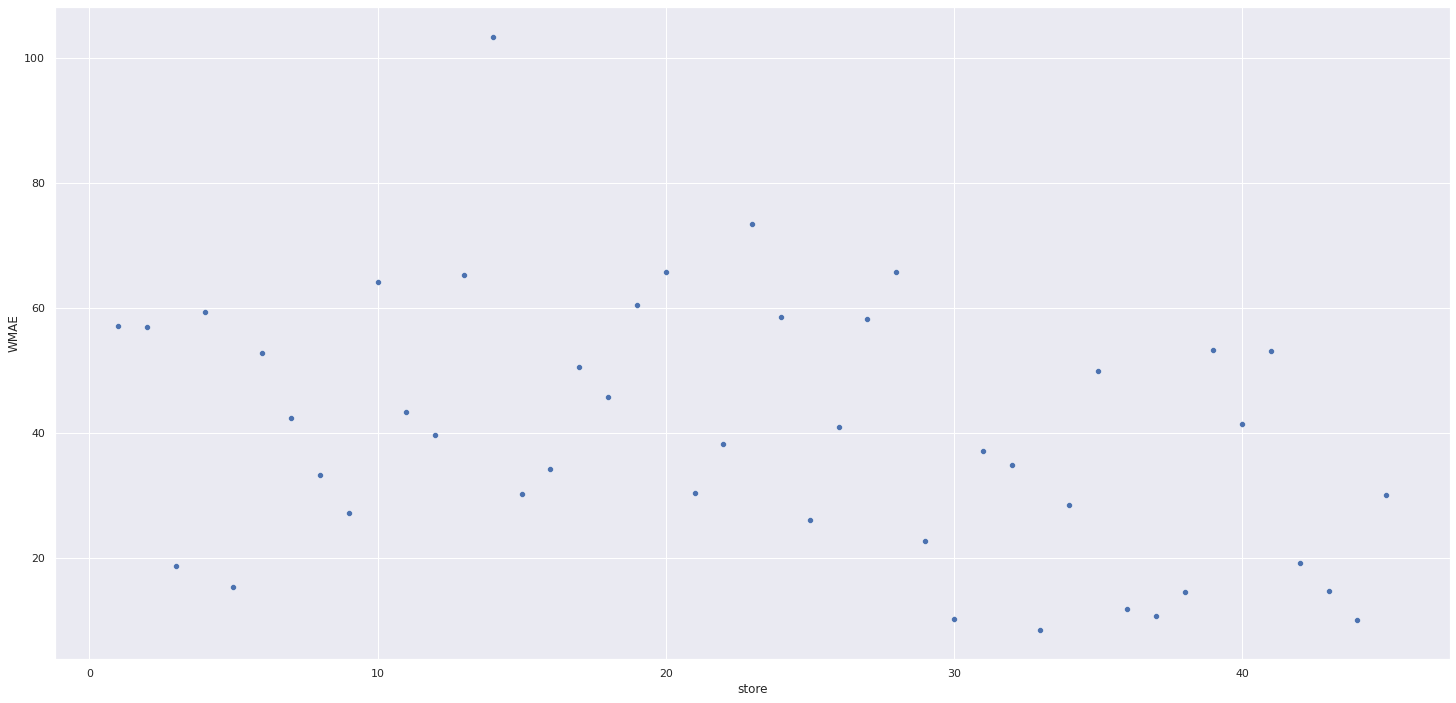

In [42]:
# scatterplot
sns.scatterplot(x = 'store', y = 'WMAE', data = df132 );

### 13.2 Business Performance - Department Granularity

In [44]:
# sum of prediction
df10 = df13[['store', 'dept', 'predictions']].groupby(['store','dept']).sum().reset_index()

# MAE and MAPE
df10_aux1 = df13[['store', 'dept', 'weekly_sales', 'predictions']].groupby(['store','dept']).apply(lambda x: mean_absolute_error(x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAE'})

df10_aux2 = df13[['store', 'dept', 'weekly_sales', 'predictions']].groupby(['store','dept']).apply(lambda x: mean_absolute_percentage_error(x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'MAPE'})

df10_aux3 = df13[['store', 'dept', 'weekly_sales', 'predictions']].groupby(['store','dept']).apply(lambda x: weighted_mean_absolute_error(df13 ,x['weekly_sales'], x['predictions']) ).reset_index().rename(columns = {0: 'WMAE'})


# merge
df10_aux4 = pd.merge(df10_aux1, df10_aux2, how = 'inner', on = ['store','dept'])
df10_aux5 = pd.merge(df10_aux4, df10_aux3, how = 'inner', on = ['store','dept'])

df12 = pd.merge(df10, df10_aux5, how = 'inner', on = ['store','dept'])

# Scenerios

df12['worst_scenario'] = df12['predictions'] - df12['MAE']
df12['best_scenario'] = df12['predictions'] + df12['MAE']


df12 = df12[['store','dept', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE', 'WMAE']]

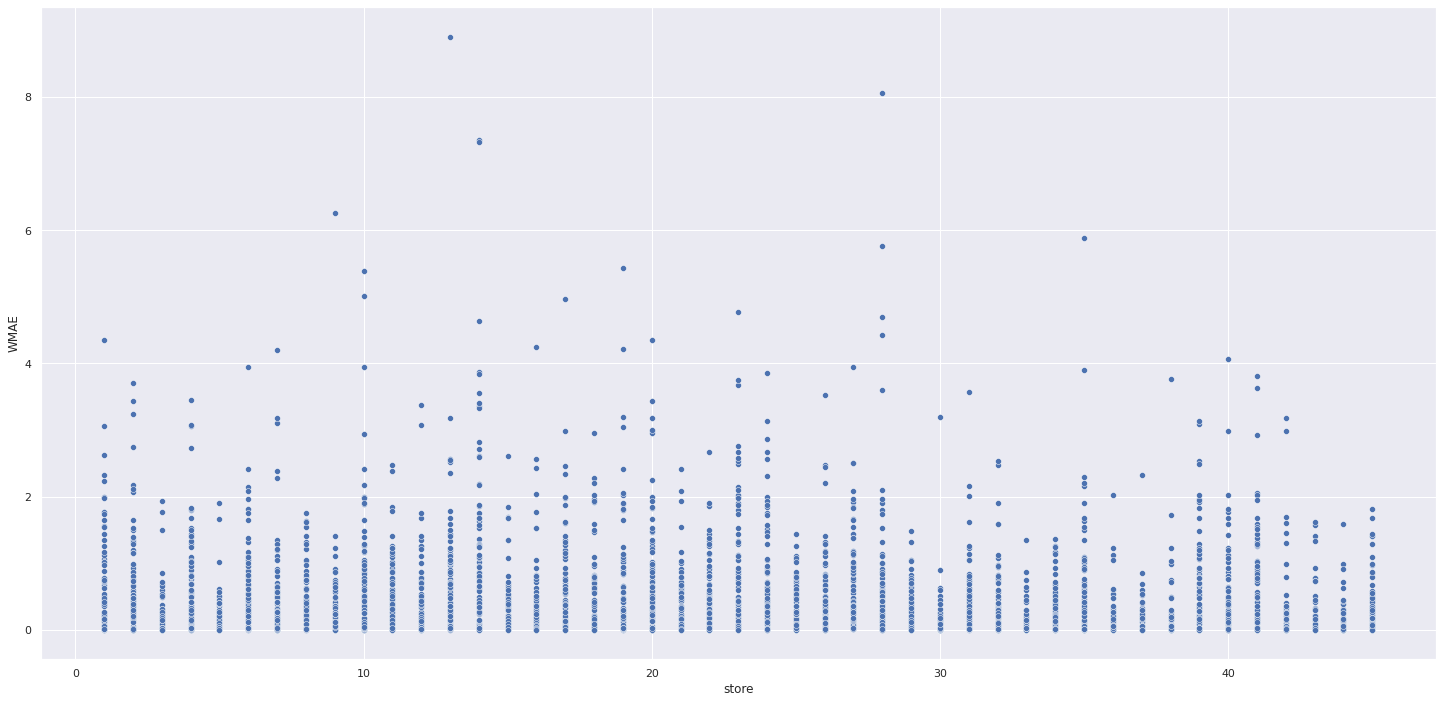

In [45]:
# scatterplot
sns.scatterplot(x = 'store', y = 'WMAE', data = df12 );

### 13.3 Total Performance

In [46]:
# Total Walmart sales predictions for the next 22 weeks
df133 = df132[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df133['Values'] = df133['Values'].map( 'R$ {:,.2f}'.format )
df133

Scenario               Values
0     predictions  R$ 1,066,156,707.95
1  worst_scenario  R$ 1,066,080,244.73
2   best_scenario  R$ 1,066,233,171.18

### 13.4 Machine Learning Performance 

In [48]:
# defining error and error rate
df13['error'] = df13['weekly_sales'] - df13['predictions']
df13['error_rate'] = df13['predictions'] / df13['weekly_sales']

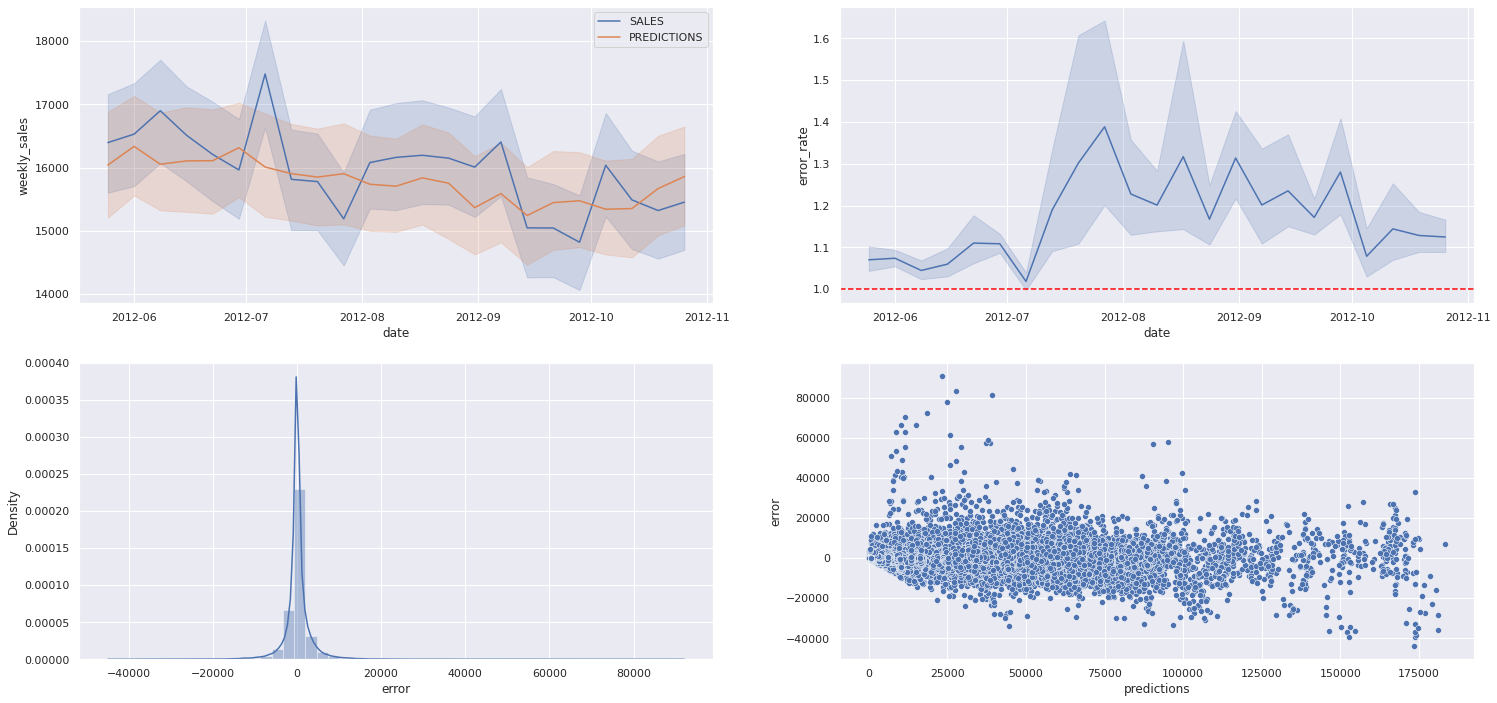

In [51]:
# ML error analysis
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='weekly_sales', data=df13, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df13, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df13 )
plt.axhline( 1, linestyle='--', color = 'red')

plt.subplot( 2, 2, 3 )
sns.distplot( df13['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df13['predictions'], df13['error'] );
plt.style.use('tableau-colorblind10');

- The first graph above shows us the predictions (orage line) which tends to follow the sales values (blue line) over the last 22 weeks of sales, meaning that the model predicted well the sales, so it is following a good pattern.

- The second graph shows us the error rate against the sales. The error rate is the ratio between prediction values and observed values. The model does have some high rates, it could performe better.

- One of the premises for a good machine learning model is to have a normal-shaped distribution of residuals with mean zero. In the third graph, we can observe that the errors are centered around zero, and its distribution resembles a normal, bell-shaped curve.

- The last graph is a scatterplot with predictions plotted against the error for each sales day. Ideally, we would have all data points concentrated within a "tube" since it represents low error variance across all values that sales prediction can assume. In our case some predictions have high error values, so we can stress more the model or create better features to get better performance.

## 14 MODEL SUBMISSION
<a id="section-fourteen"></a>

In [54]:
model_rf_tuned

RandomForestRegressor(max_features='auto', min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=7)

In [55]:
# Save Trained Model
pickle.dump(model_rf_tuned, open(home_path + 'model/model_walmart.pkl', 'wb'))

### 14.1 Loading Model and Scalers

In [5]:
#loading scalers
#Robust Scaler 
temperature_scaler  = pickle.load(open(home_path + 'parameters/temperature_scaler.pkl', 'rb'))
mark_down1_scaler   = pickle.load(open(home_path + 'parameters/mark_down1_scaler.pkl', 'rb'))
mark_down2_scaler   = pickle.load(open(home_path + 'parameters/mark_down2_scaler.pkl', 'rb'))
mark_down3_scaler   = pickle.load(open(home_path + 'parameters/mark_down3_scaler.pkl', 'rb'))
mark_down4_scaler   = pickle.load(open(home_path + 'parameters/mark_down4_scaler.pkl', 'rb'))
mark_down5_scaler   = pickle.load(open(home_path + 'parameters/mark_down5_scaler.pkl', 'rb'))
unemployment_scaler = pickle.load(open(home_path + 'parameters/unemployment_scaler.pkl', 'rb'))

#MinMax Scaler 
fuel_price_scaler   = pickle.load(open(home_path + 'parameters/fuel_price_scaler.pkl', 'rb'))
cpi_scaler          = pickle.load(open(home_path + 'parameters/cpi_scaler.pkl', 'rb'))
size_scaler         = pickle.load(open(home_path + 'parameters/size_scaler.pkl', 'rb'))
year_scaler         = pickle.load(open(home_path + 'parameters/year_scaler.pkl', 'rb'))

#Label enconder
type_scaler         = pickle.load(open(home_path + 'parameters/type_scaler.pkl', 'rb'))

In [8]:
# loading trained model
model = pickle.load(open(home_path + 'model/model_walmart.pkl', 'rb'))

### 14.2 Data ETL

In [13]:
# defining data pipeline
def data_merge(df_test, df_features, df_stores):
    # merge datasets into one
    df_store_feature = df_features.merge(df_stores, on = 'Store', how = 'left')
    
    # main dataframe for exploring
    df_test = df_test.merge(df_store_feature, on = ['Store', 'Date', 'IsHoliday'], how = 'left').sort_values(['Store','Dept','Date'])
    return df_test

def data_cleaning(df1):
    ### Rename Columns
    cols_old = df1.columns
    snakecase = lambda x: inflection.underscore(x)
    
    cols_new = list( map( snakecase, cols_old ) )
    #Rename Columns
    df1.columns = cols_new
    
    # replacing NAs with 0
    df1 = df1.fillna(0)

    #converting feature 'date' to datetime
    df1['date'] = pd.to_datetime( df1[ 'date' ] )
    
    return df1

def data_feature_engineering(df2):
    # year
    df2['year'] = df2['date'].dt.year

    # month
    df2['month'] = df2['date'].dt.month
    
    # day
    df2['day'] = df2['date'].dt.day
    
    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
    
    # year week
    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
    
    # year quarter
    df2['quarter'] = df2['date'].dt.to_period('Q')
    
    return df2

def data_preparation(df5):
    # Applying all transformations on validation dataset
    #Validation dataset features transform - Robust Scaler
    df5['temperature'] = temperature_scaler.transform( df5[['temperature']].values ) 
    df5['mark_down1']  = mark_down1_scaler.transform( df5[['mark_down1']].values ) 
    df5['mark_down2']  = mark_down2_scaler.transform( df5[['mark_down2']].values ) 
    df5['mark_down3']  = mark_down3_scaler.transform( df5[['mark_down3']].values ) 
    df5['mark_down4']  = mark_down4_scaler.transform( df5[['mark_down4']].values ) 
    df5['mark_down5']  = mark_down5_scaler.transform( df5[['mark_down5']].values ) 
    df5['unemployment']= unemployment_scaler.transform( df5[['unemployment']].values ) 
    
    ##Validation dataset features transform - MinMaxScaler
    df5['fuel_price'] = fuel_price_scaler.transform( df5[['fuel_price']].values )
    df5['cpi']        = cpi_scaler.transform( df5[['cpi']].values )
    df5['size']       = size_scaler.transform( df5[['size']].values )
    df5['year']       = year_scaler.transform( df5[['year']].values )
    
    ##Validation dataset features transform - Label Enconder
    df5['type'] = type_scaler.transform( df5['type'] )
    
    # is_holiday
    df5['is_holiday'] = df5['is_holiday'].apply(lambda x: 1 if x == True else 0)
    
    ##Validation dataset features transform - Natural Transformations
    # month
    df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
    
    # day 
    df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
    
    # week_of_year
    df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
    df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
    
    cols_selected = ['store','dept','is_holiday','type','cpi','size','month_cos','week_of_year_cos']
    return df5[cols_selected]

def get_prediction(model, original_data, test_data):
    # prediction
    pred = model.predict(test_data)
    
    # join pred into the original data so people can undestandt it the new table with prediction column
    original_data['weekly_sales'] = np.expm1(pred)
    
    #creatomg id column
    original_data['id'] = original_data['Store'].astype(str) + '_' +  original_data['Dept'].astype(str) + '_' +  original_data['Date'].astype(str)
    original_data = original_data[['id', 'weekly_sales']].copy()
    return original_data
        # original_data.to_csv('submission.csv',index=False)

In [14]:
#Applying ETL into test dataset

df1_test = data_merge(df_test_raw, df_features, df_stores)

df2_test = data_cleaning(df1_test)

df3_test = data_feature_engineering(df2_test)

df4_test = data_preparation(df3_test)

df_submission = get_prediction(model, df_test_raw, df4_test)

In [2]:
# Final result
df_submission.head()

NameError: name 'df_submission' is not defined

In [1]:
df_submission.to_csv('submission.csv',index=False)

NameError: name 'df_submission' is not defined